# このNotebookについて

このNotebookでは、SPEファイルを回転させる処理の開発(と簡単なテスト)を行います。

# 事前処理

In [1]:
# 外部ライブラリのimport
import os
import sys
import time

import numpy as np
import scipy.ndimage
from matplotlib import pyplot as plt

In [2]:
# 自作ライブラリのimport

# ファイル読み込み
from modules.file_format.spe_wrapper import SpeWrapper
# データ処理
from modules.data_model.raw_spectrum_data import RawSpectrumData, RotateOption
# Fittingクラス
from modules.radiation_fitter import RadiationFitter
# 図を作る処理を書いたクラス
from modules.figure_maker import FigureMaker
# しきい値を決定するときに使うクラス
from modules.calculator import HistogramFitter

In [3]:
# 不要
# rootを確認する
sys.path

['/Users/ishizawaosamu/work/MasterThesis/RadiationSpectraRotator',
 '/usr/local/Cellar/python@3.12/3.12.6/Frameworks/Python.framework/Versions/3.12/lib/python312.zip',
 '/usr/local/Cellar/python@3.12/3.12.6/Frameworks/Python.framework/Versions/3.12/lib/python3.12',
 '/usr/local/Cellar/python@3.12/3.12.6/Frameworks/Python.framework/Versions/3.12/lib/python3.12/lib-dynload',
 '',
 '/Users/ishizawaosamu/work/MasterThesis/RadiationSpectraRotator/.venv/lib/python3.12/site-packages']

# テストデータの読み込み

In [4]:
# 生の露光データファイルの場所
path_to_data = '/Users/ishizawaosamu/work/MasterThesis/test-data/spe-rotator/OIbDia04_  02.spe'

In [5]:
# データのインスタンス化
original_spe = SpeWrapper(path_to_data) # ファイル読み込み
original_radiation = RawSpectrumData(original_spe) # ファイルデータをデータモデルに格納

In [6]:
# ファイル名を取得しておく
file_name = original_radiation.file_name + original_radiation.file_extension
file_name

'OIbDia04_  02.spe'

In [7]:
# 不要
# 実験設定メタデータの閲覧
settings = original_spe.retrieve_all_experiment_settings()

for setting in settings:
    print(setting.setting_name, setting.setting_value)

CAMERA_MODEL ProEM-HS: 512B eXcelon
SERIAL_NUMBER 01458418
SENSOR_INFORMATION E2V 512 x 512 (CCD 97)(B)(eXcelon)
PIXEL_PITCH 16.0
SENSOR_TEMPERATURE -64.0
EXPOSURE_TIME 10.0
READOUT_TIME 16.798374999999997
ADC_SPEED 20.0
BIT_DEPTH 16
ADC_ANALOG_GAIN High


## 露光データの全体を俯瞰する

In [8]:
all_max_I = original_radiation.get_max_intensity_arr()
up_max_I, down_max_I = original_radiation.get_separated_max_intensity_arr()

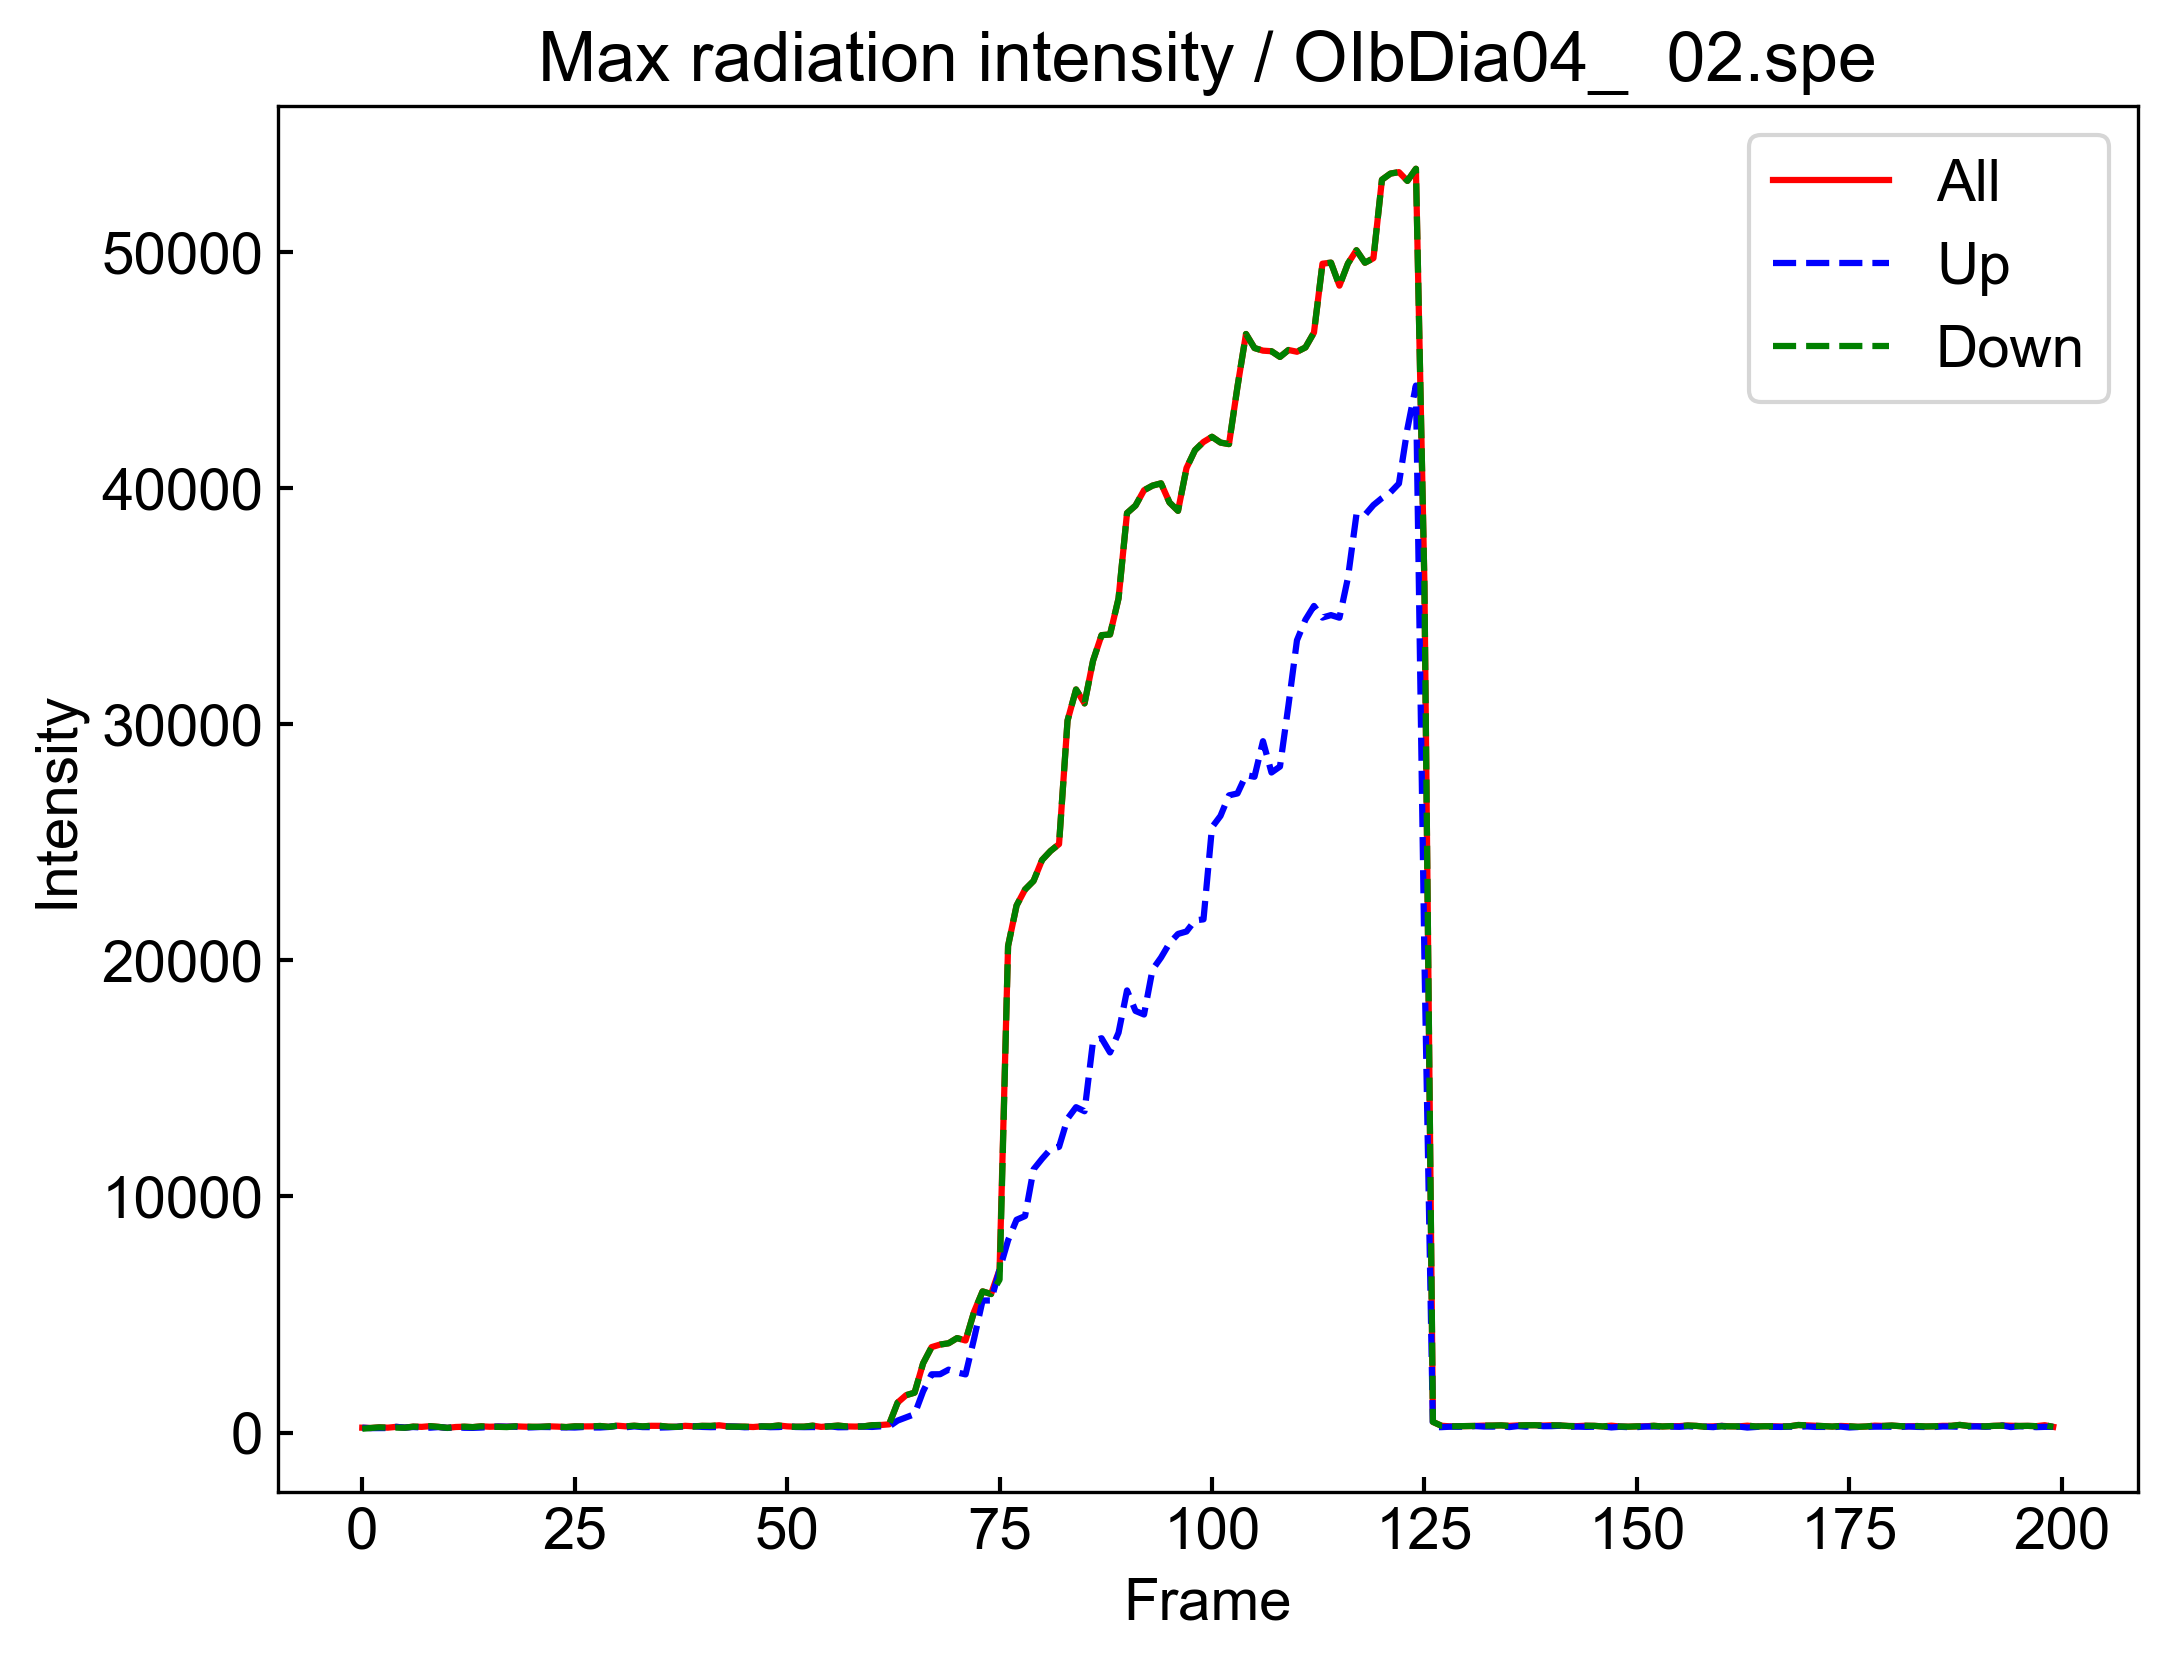

In [9]:
FigureMaker.get_max_I_figure(
    file_name,
    all_max_I,
    up_max_I, 
    down_max_I
)
plt.show()
plt.close()

## しきい値を決定

In [10]:
histogram_fitter = HistogramFitter()

In [11]:
histogram_fitter.fit_nd_histogram(
    data=all_max_I[0:40],
    bins=10
)

Fitting Results: 
Amplitude: 1.058 ± 0.374
Mean: 257.668 ± 10.092
Stddev: 26.051 ± 11.480



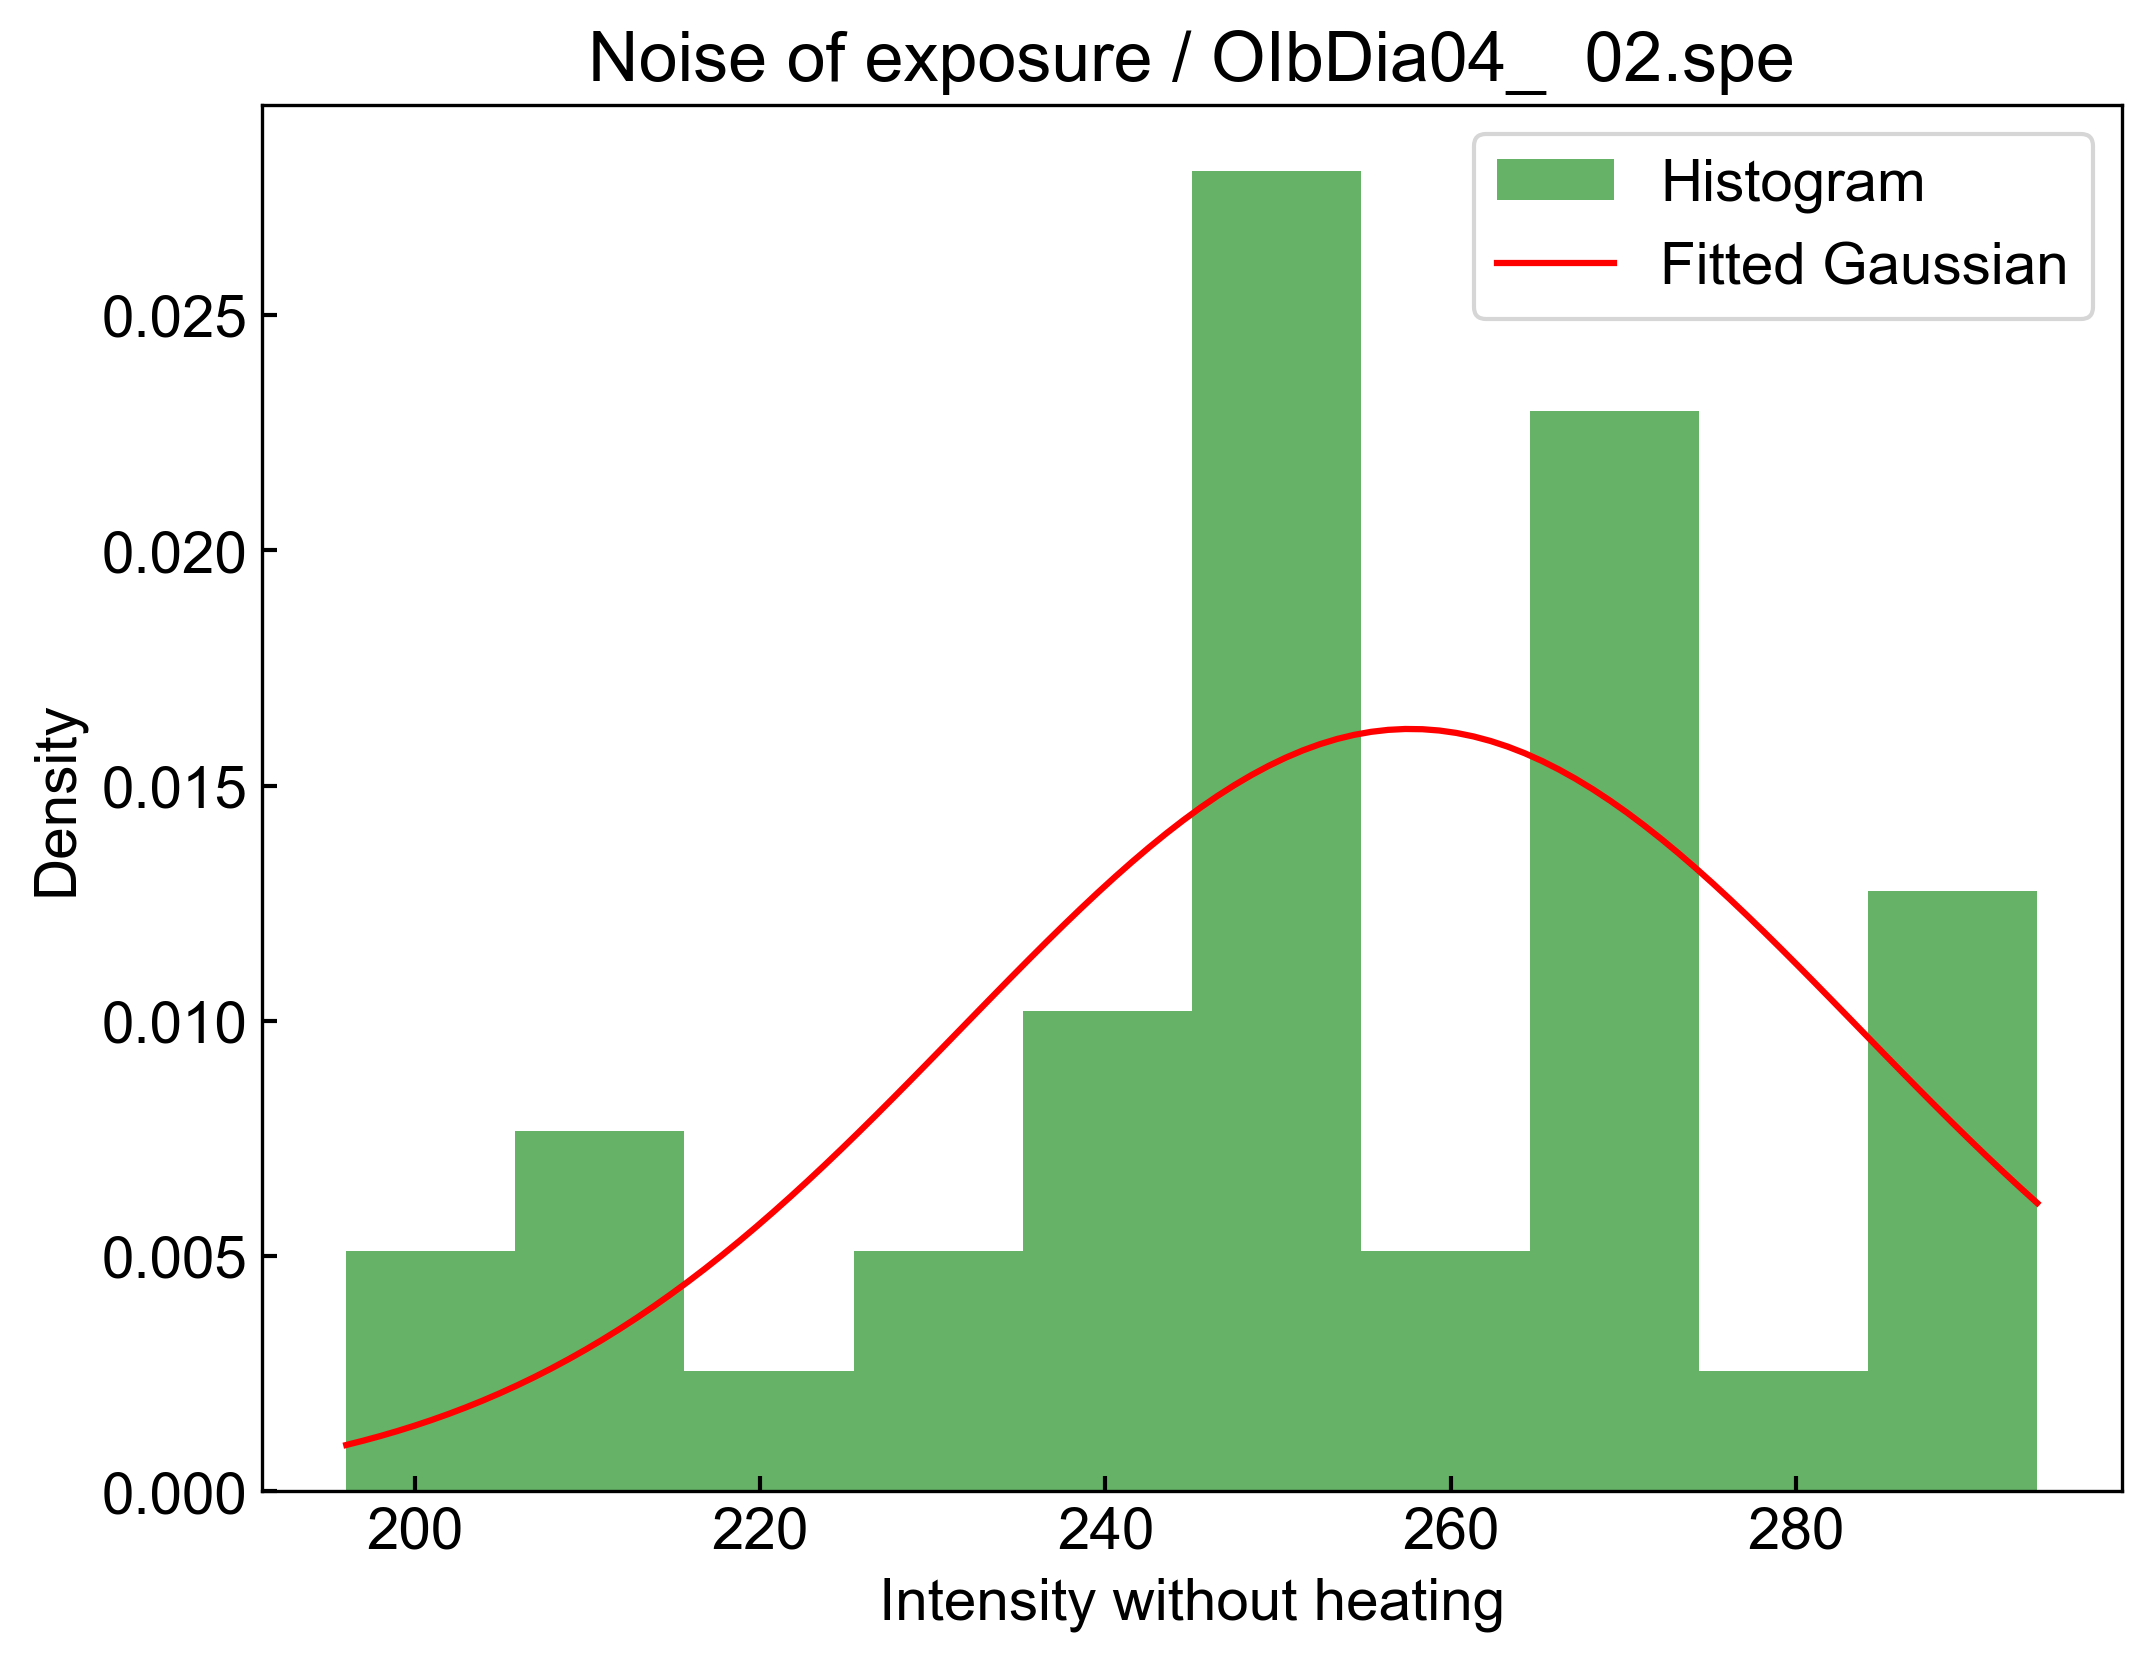

In [12]:
print(histogram_fitter.result_str)

FigureMaker.get_histgram_fit_figure(file_name, histogram_fitter)

In [13]:
histogram_fitter.result

{'amplitude': {'value': np.float64(1.0582141528986042),
  'error': np.float64(0.3735270855503927)},
 'mean': {'value': np.float64(257.66768042105053),
  'error': np.float64(10.09190233278966)},
 'stddev': {'value': np.float64(26.050625598239446),
  'error': np.float64(11.480399624092085)}}

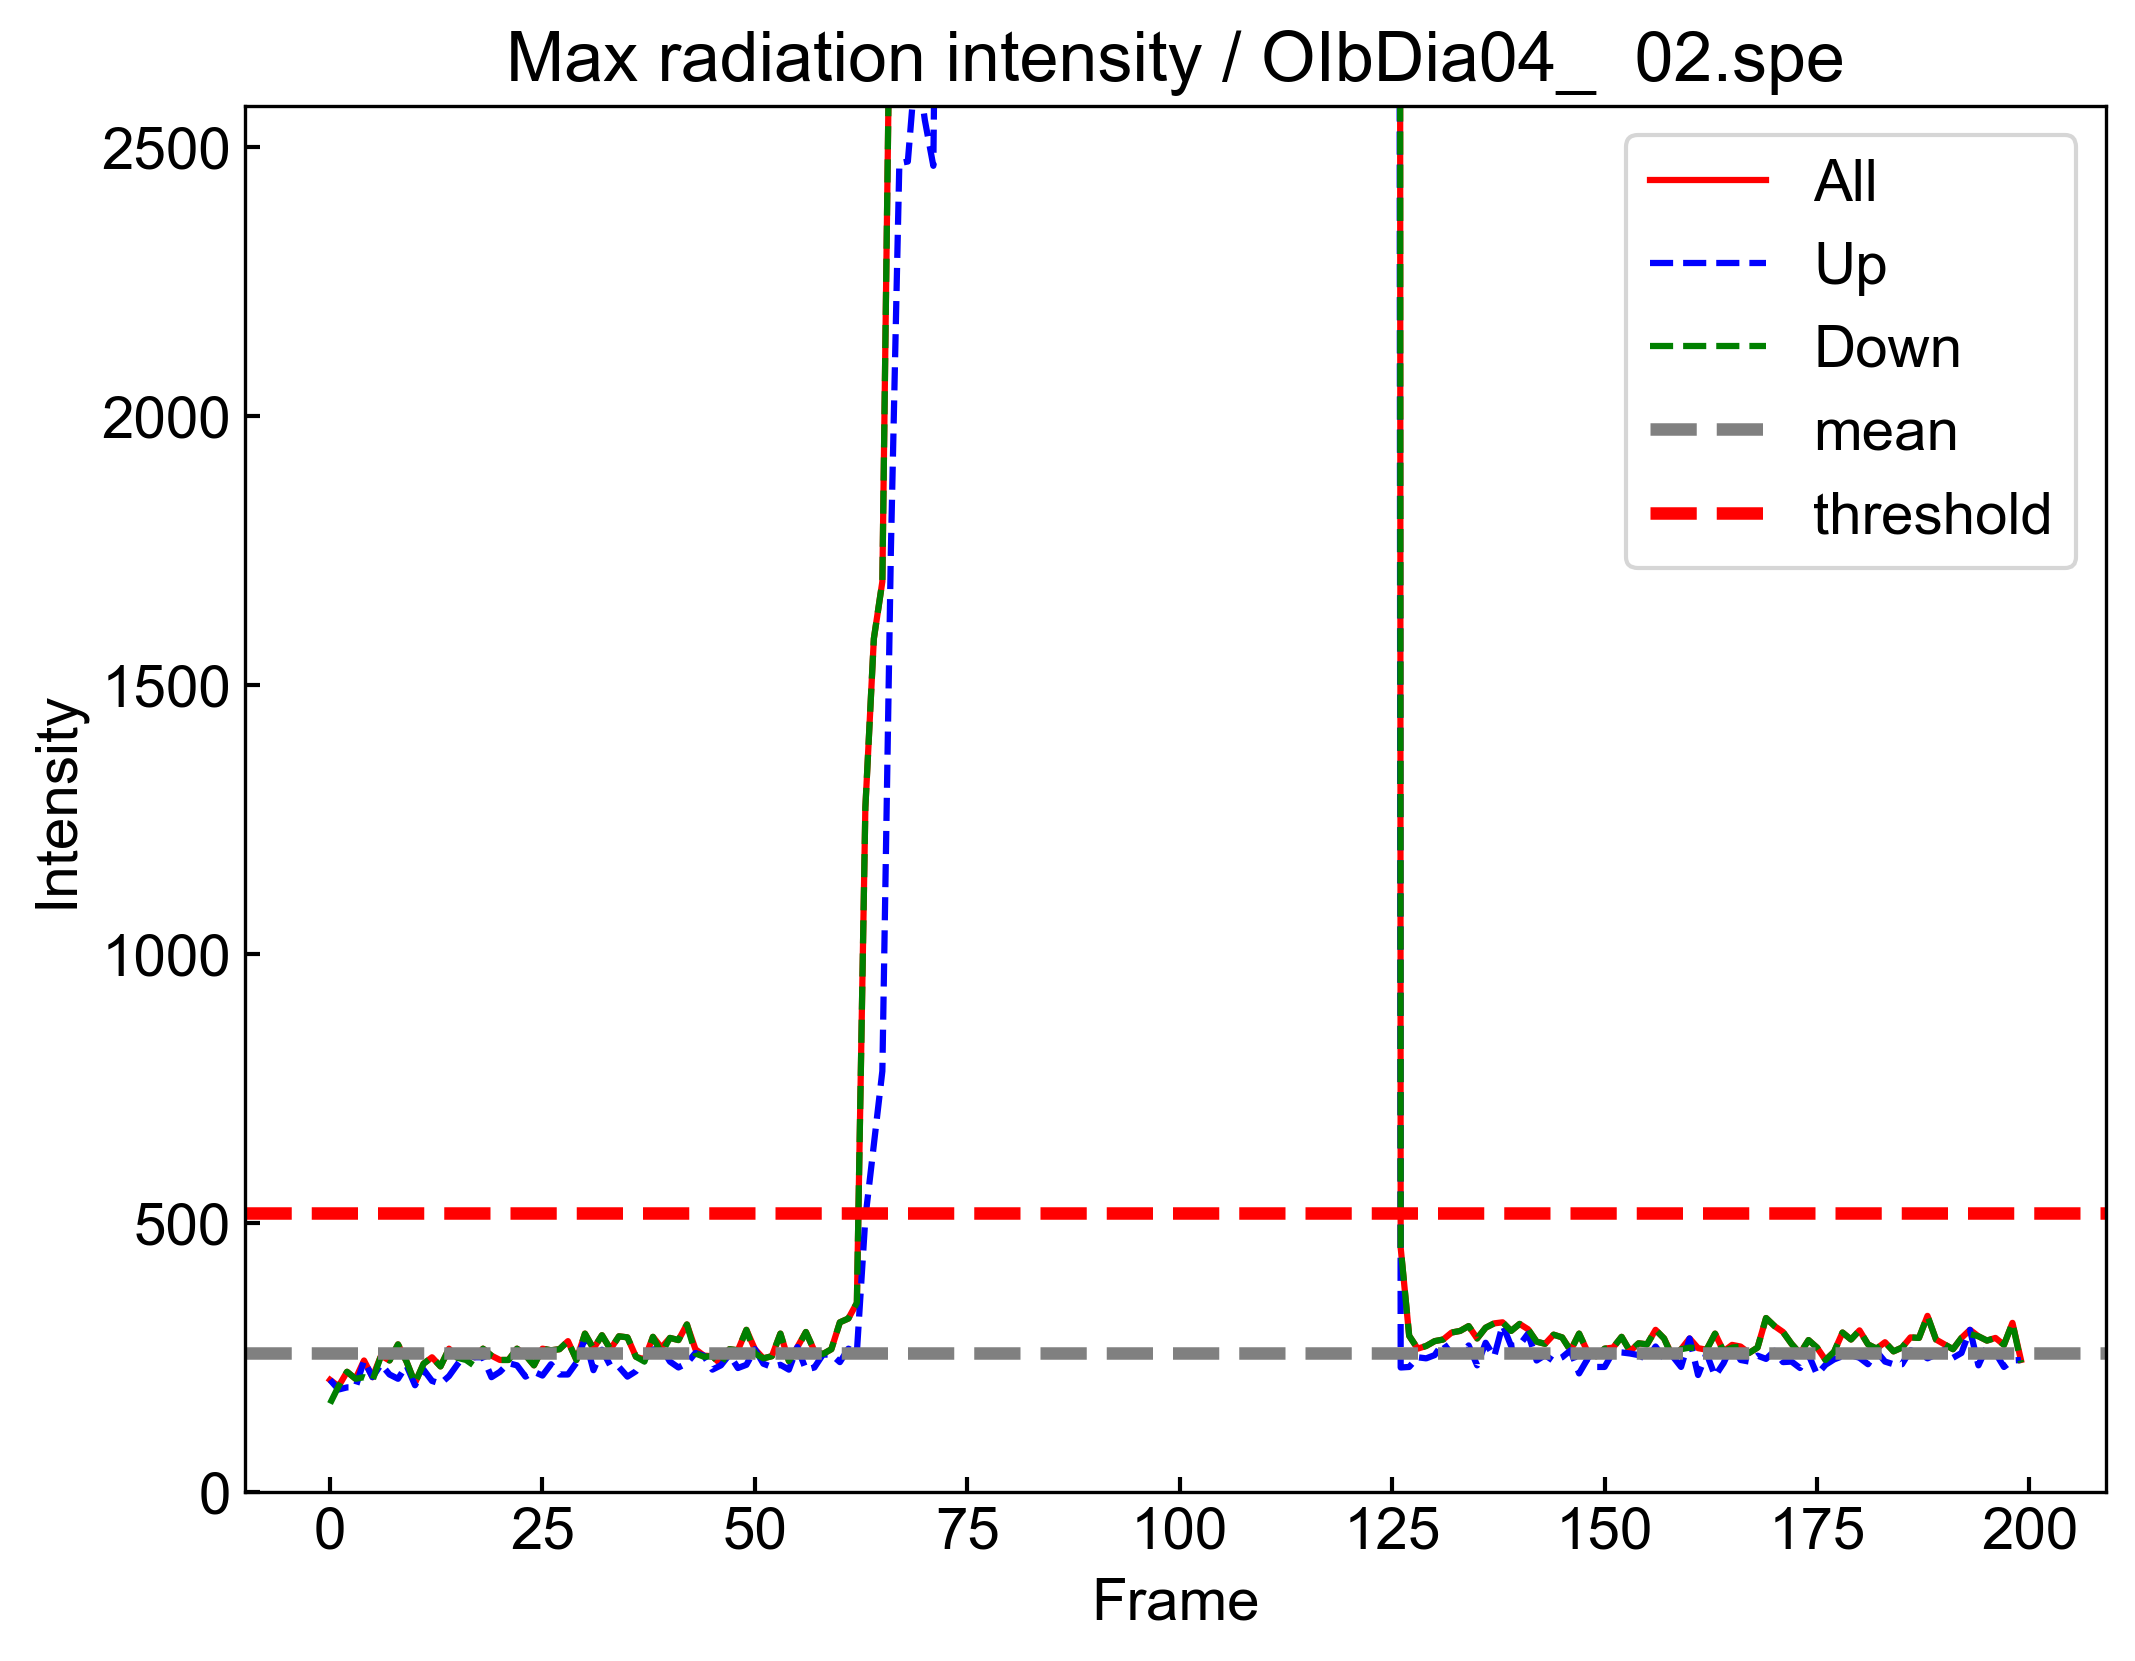

In [14]:
# しきい値を確認
result = histogram_fitter.result
threshold = result['mean']['value'] + result['stddev']['value']*10

fig = FigureMaker.get_max_I_figure(
    file_name,
    all_max_I,
    up_max_I,
    down_max_I
)

FigureMaker.overlap_max_intensity_by_threshold(
    histogram_fitter,
    threshold
)

plt.show()
plt.close()


# 処理の実装

## テストとして使うフレームを設定

In [15]:
test_frame = 120

# その露光データ
image = original_radiation.get_frame_data(test_frame)

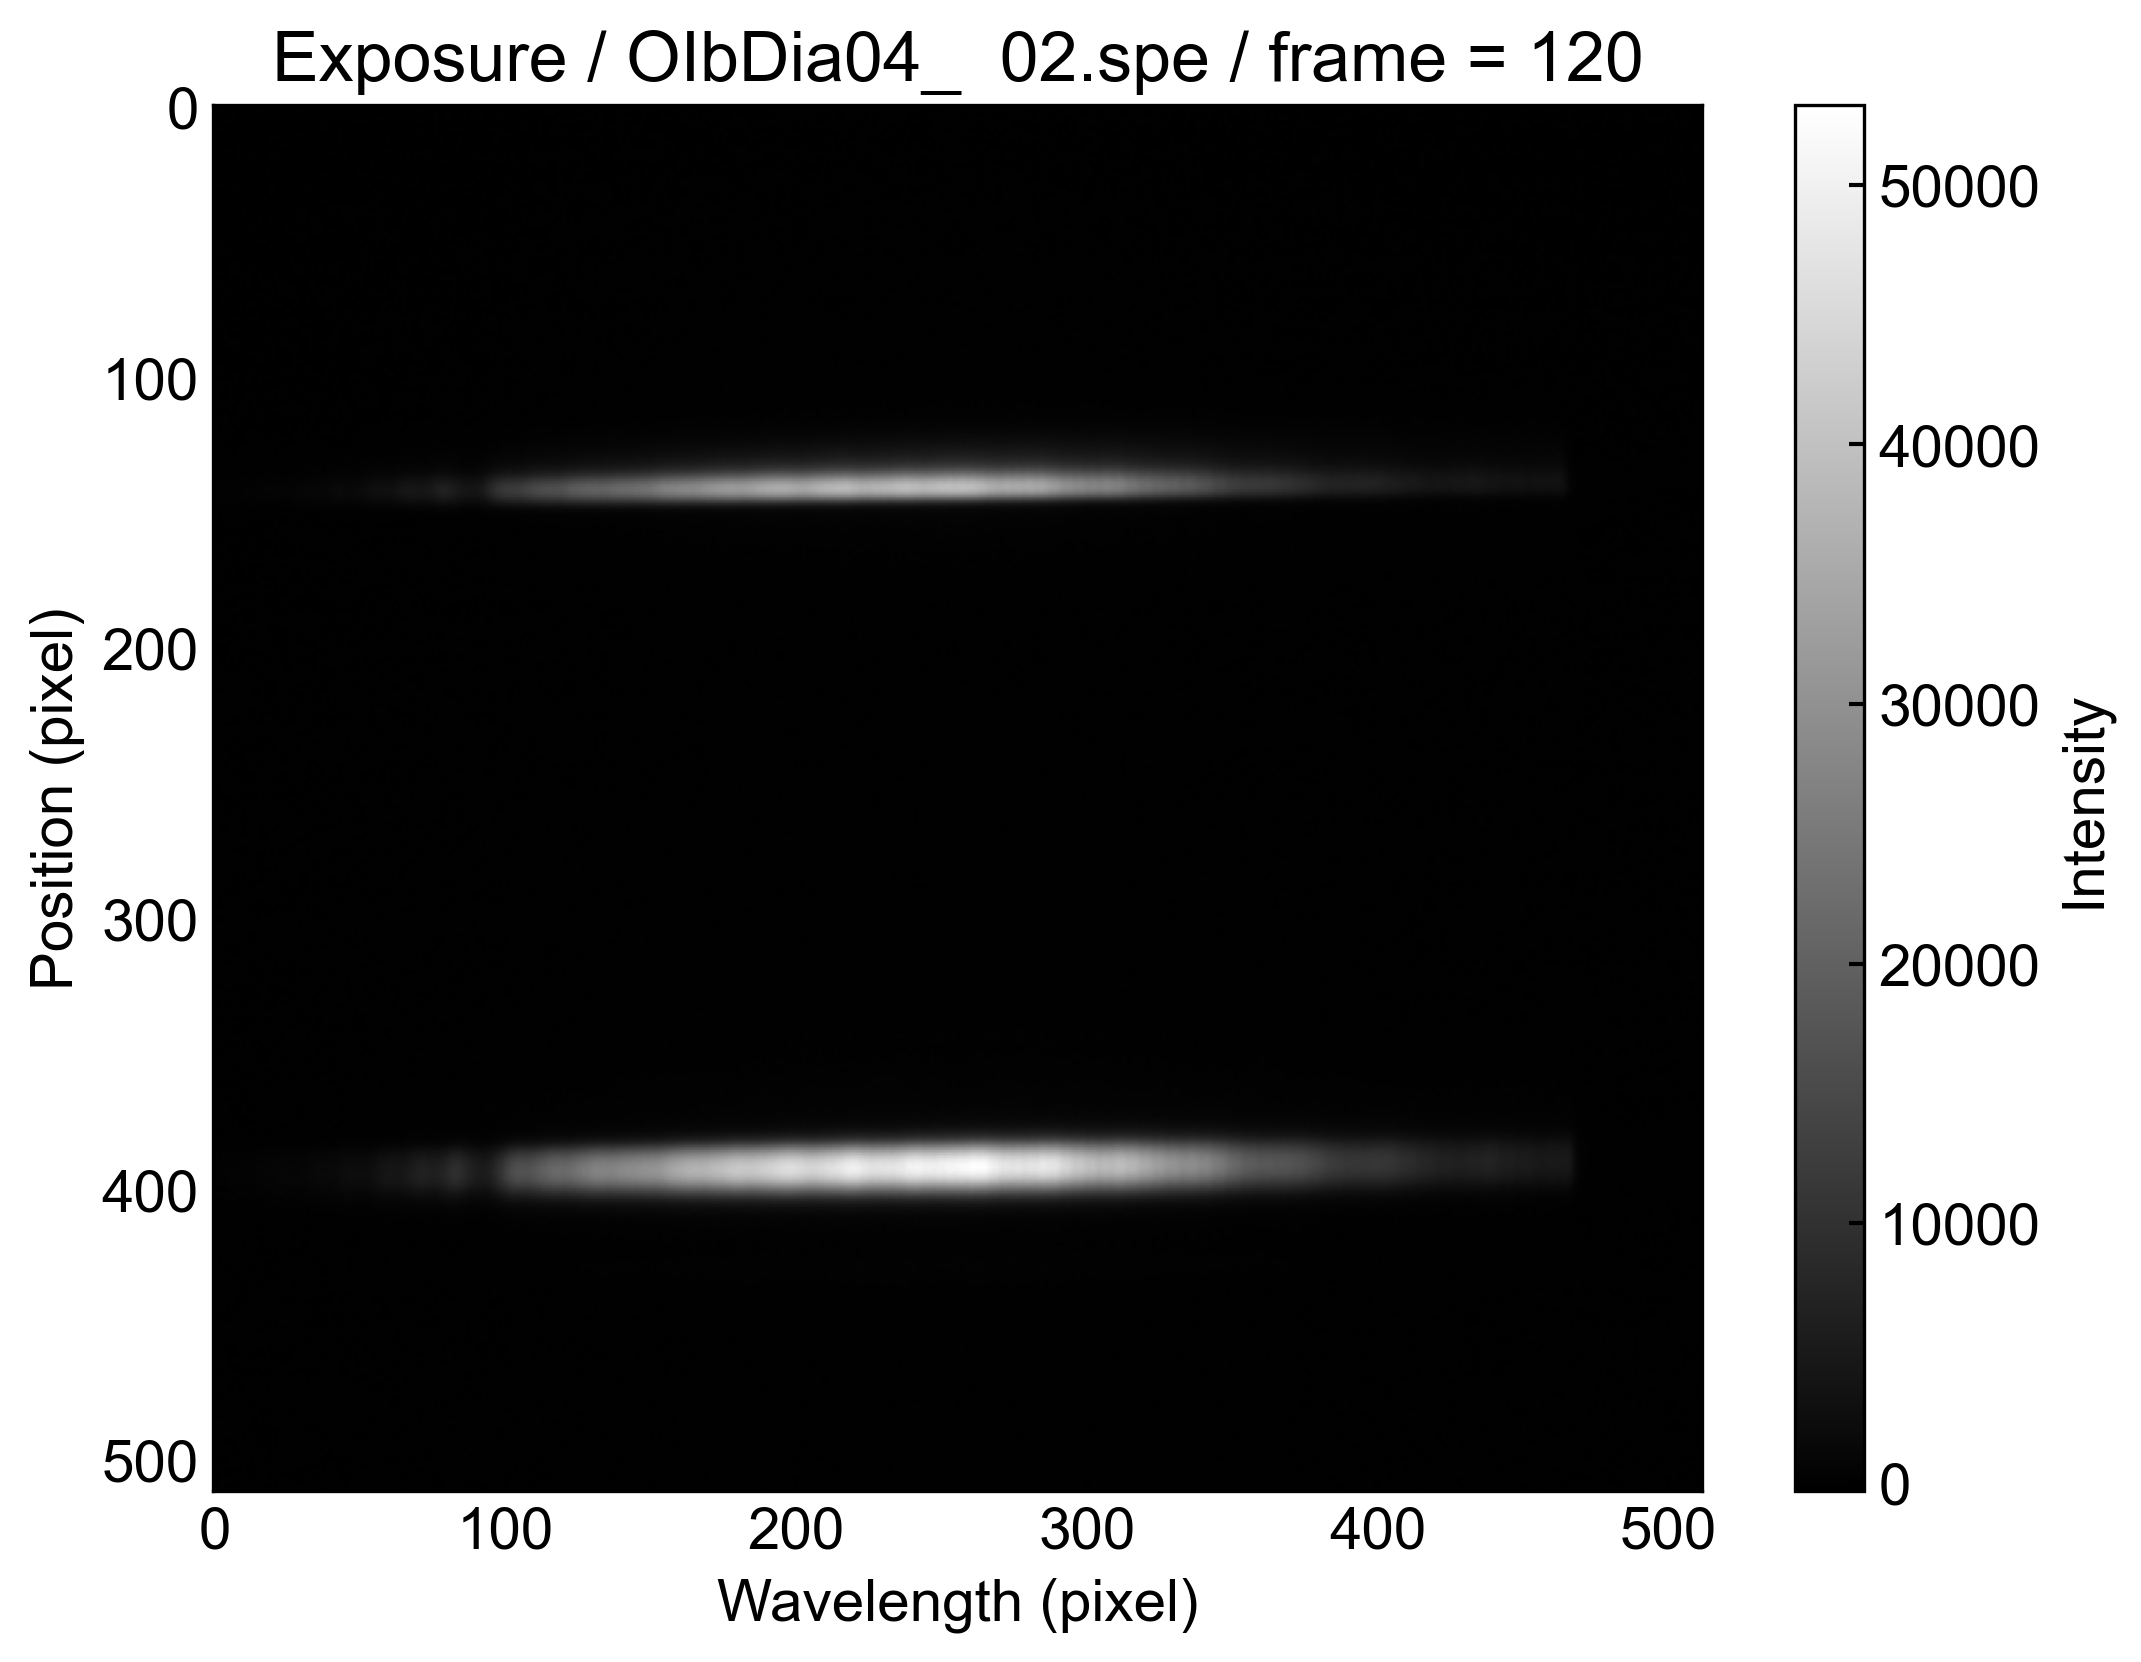

In [16]:
# ベースを描画
FigureMaker.get_exposure_image_figure(
    file_name,
    test_frame,
    image,
)
plt.show()
plt.close()

## 調べるpositionを格納する

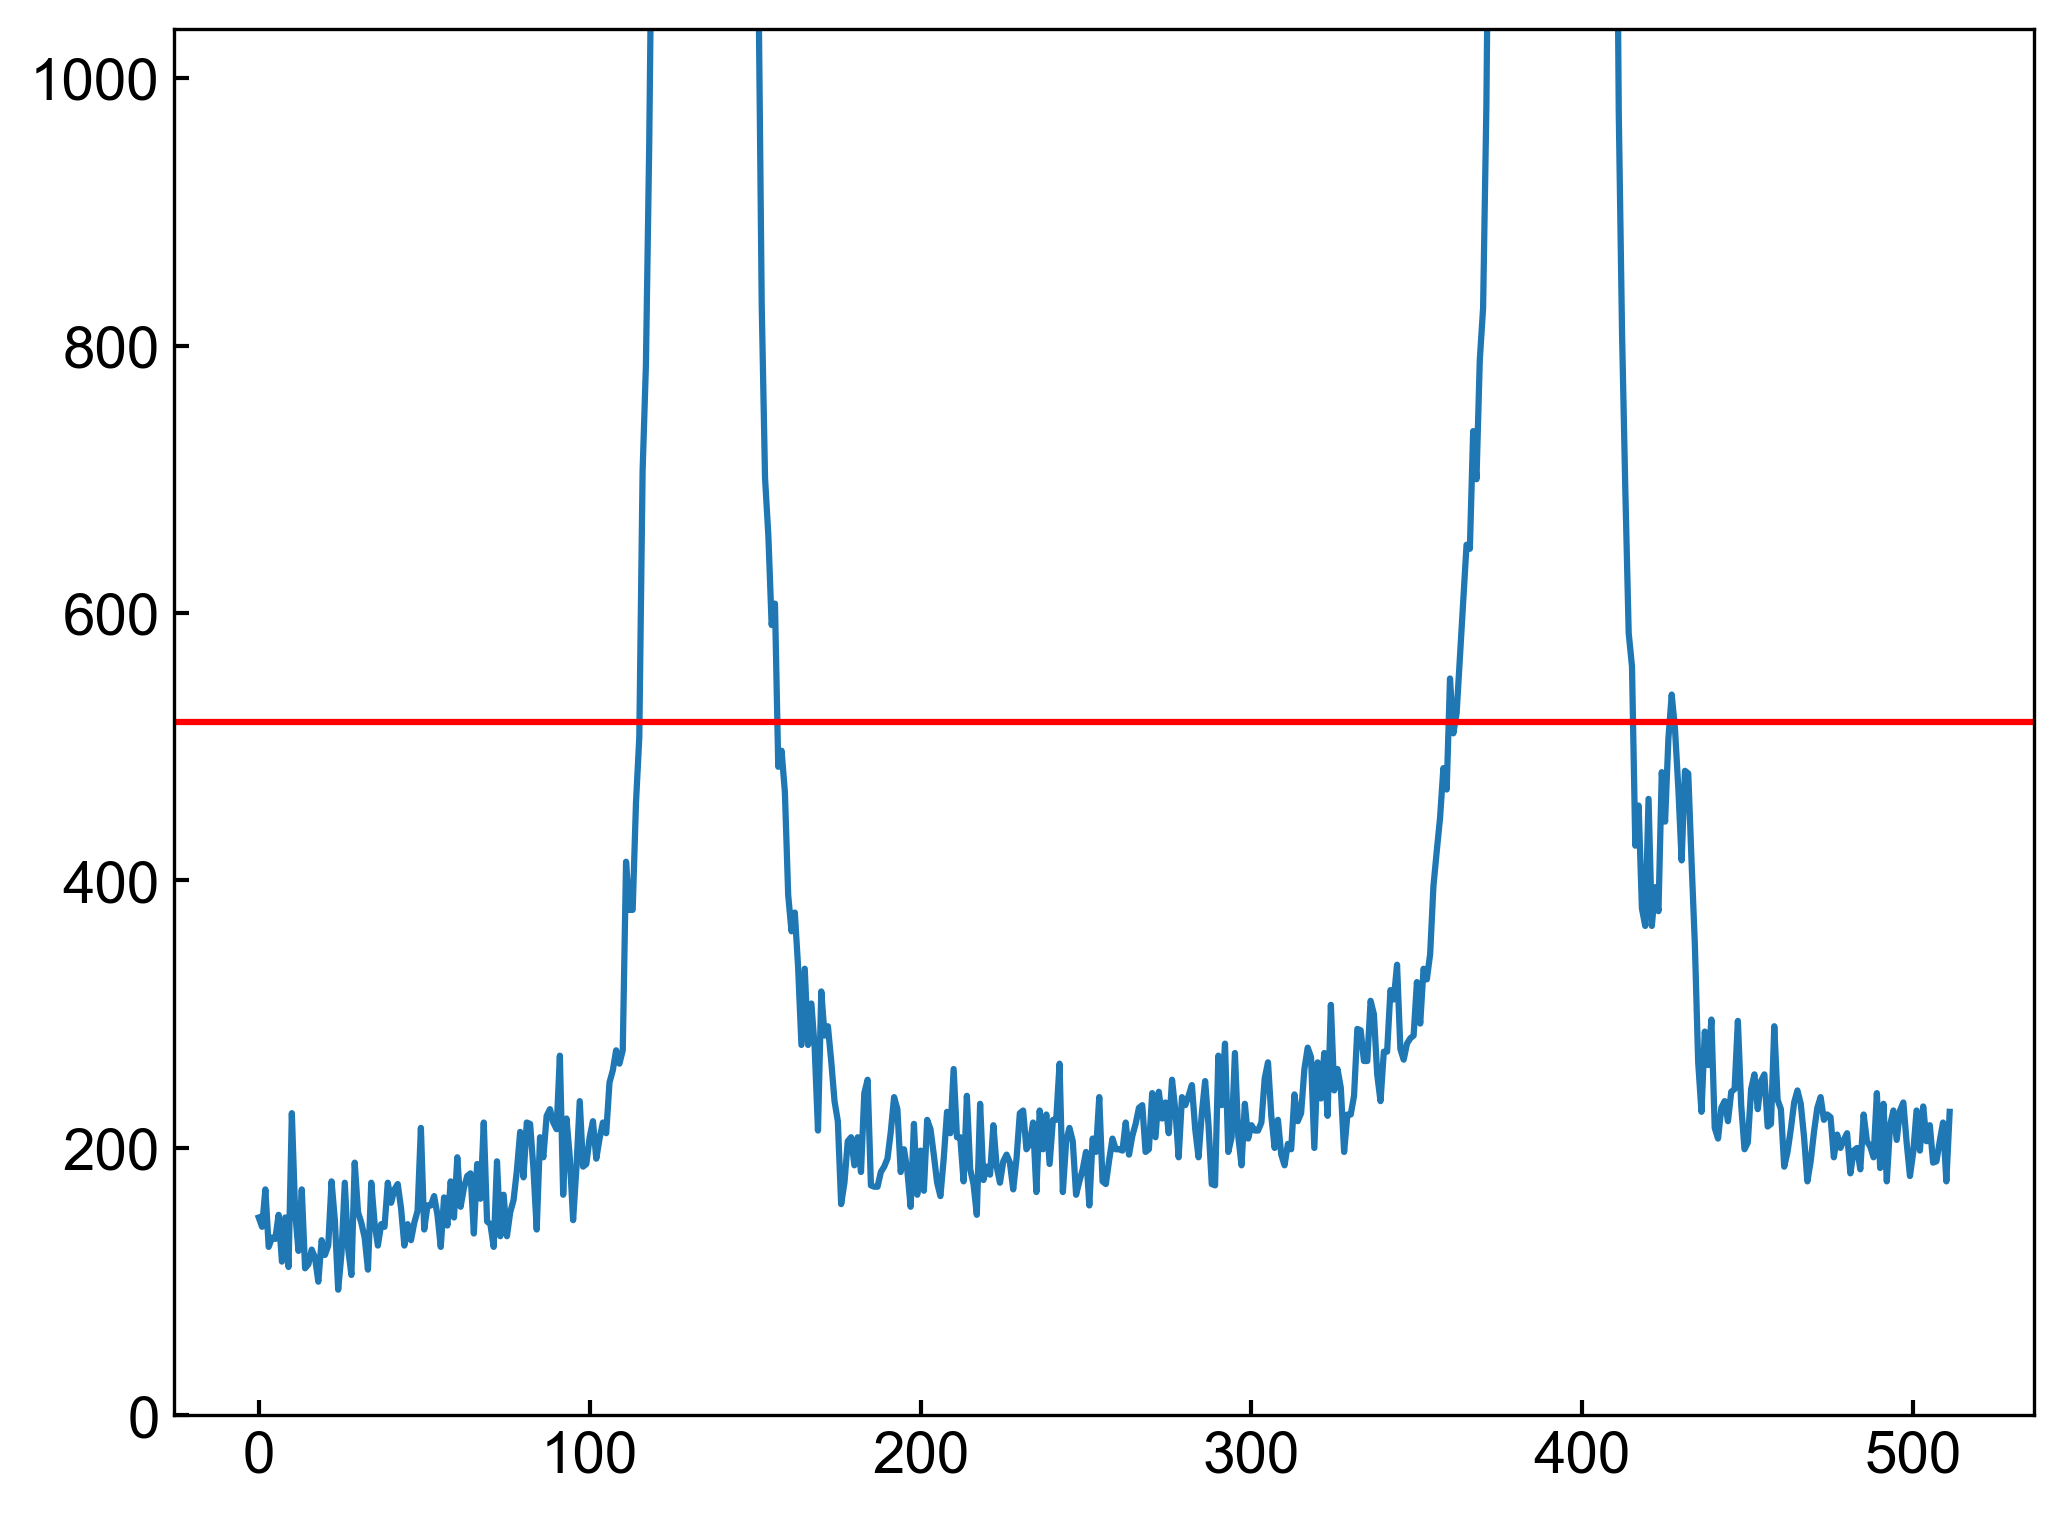

In [17]:
# しきい値以上のposition_pixelの可視化
plt.plot(image.max(axis=1)) # positionから見た最大値
plt.axhline(y=threshold, color='red')
plt.ylim(0, threshold*2)
plt.show()
plt.close()

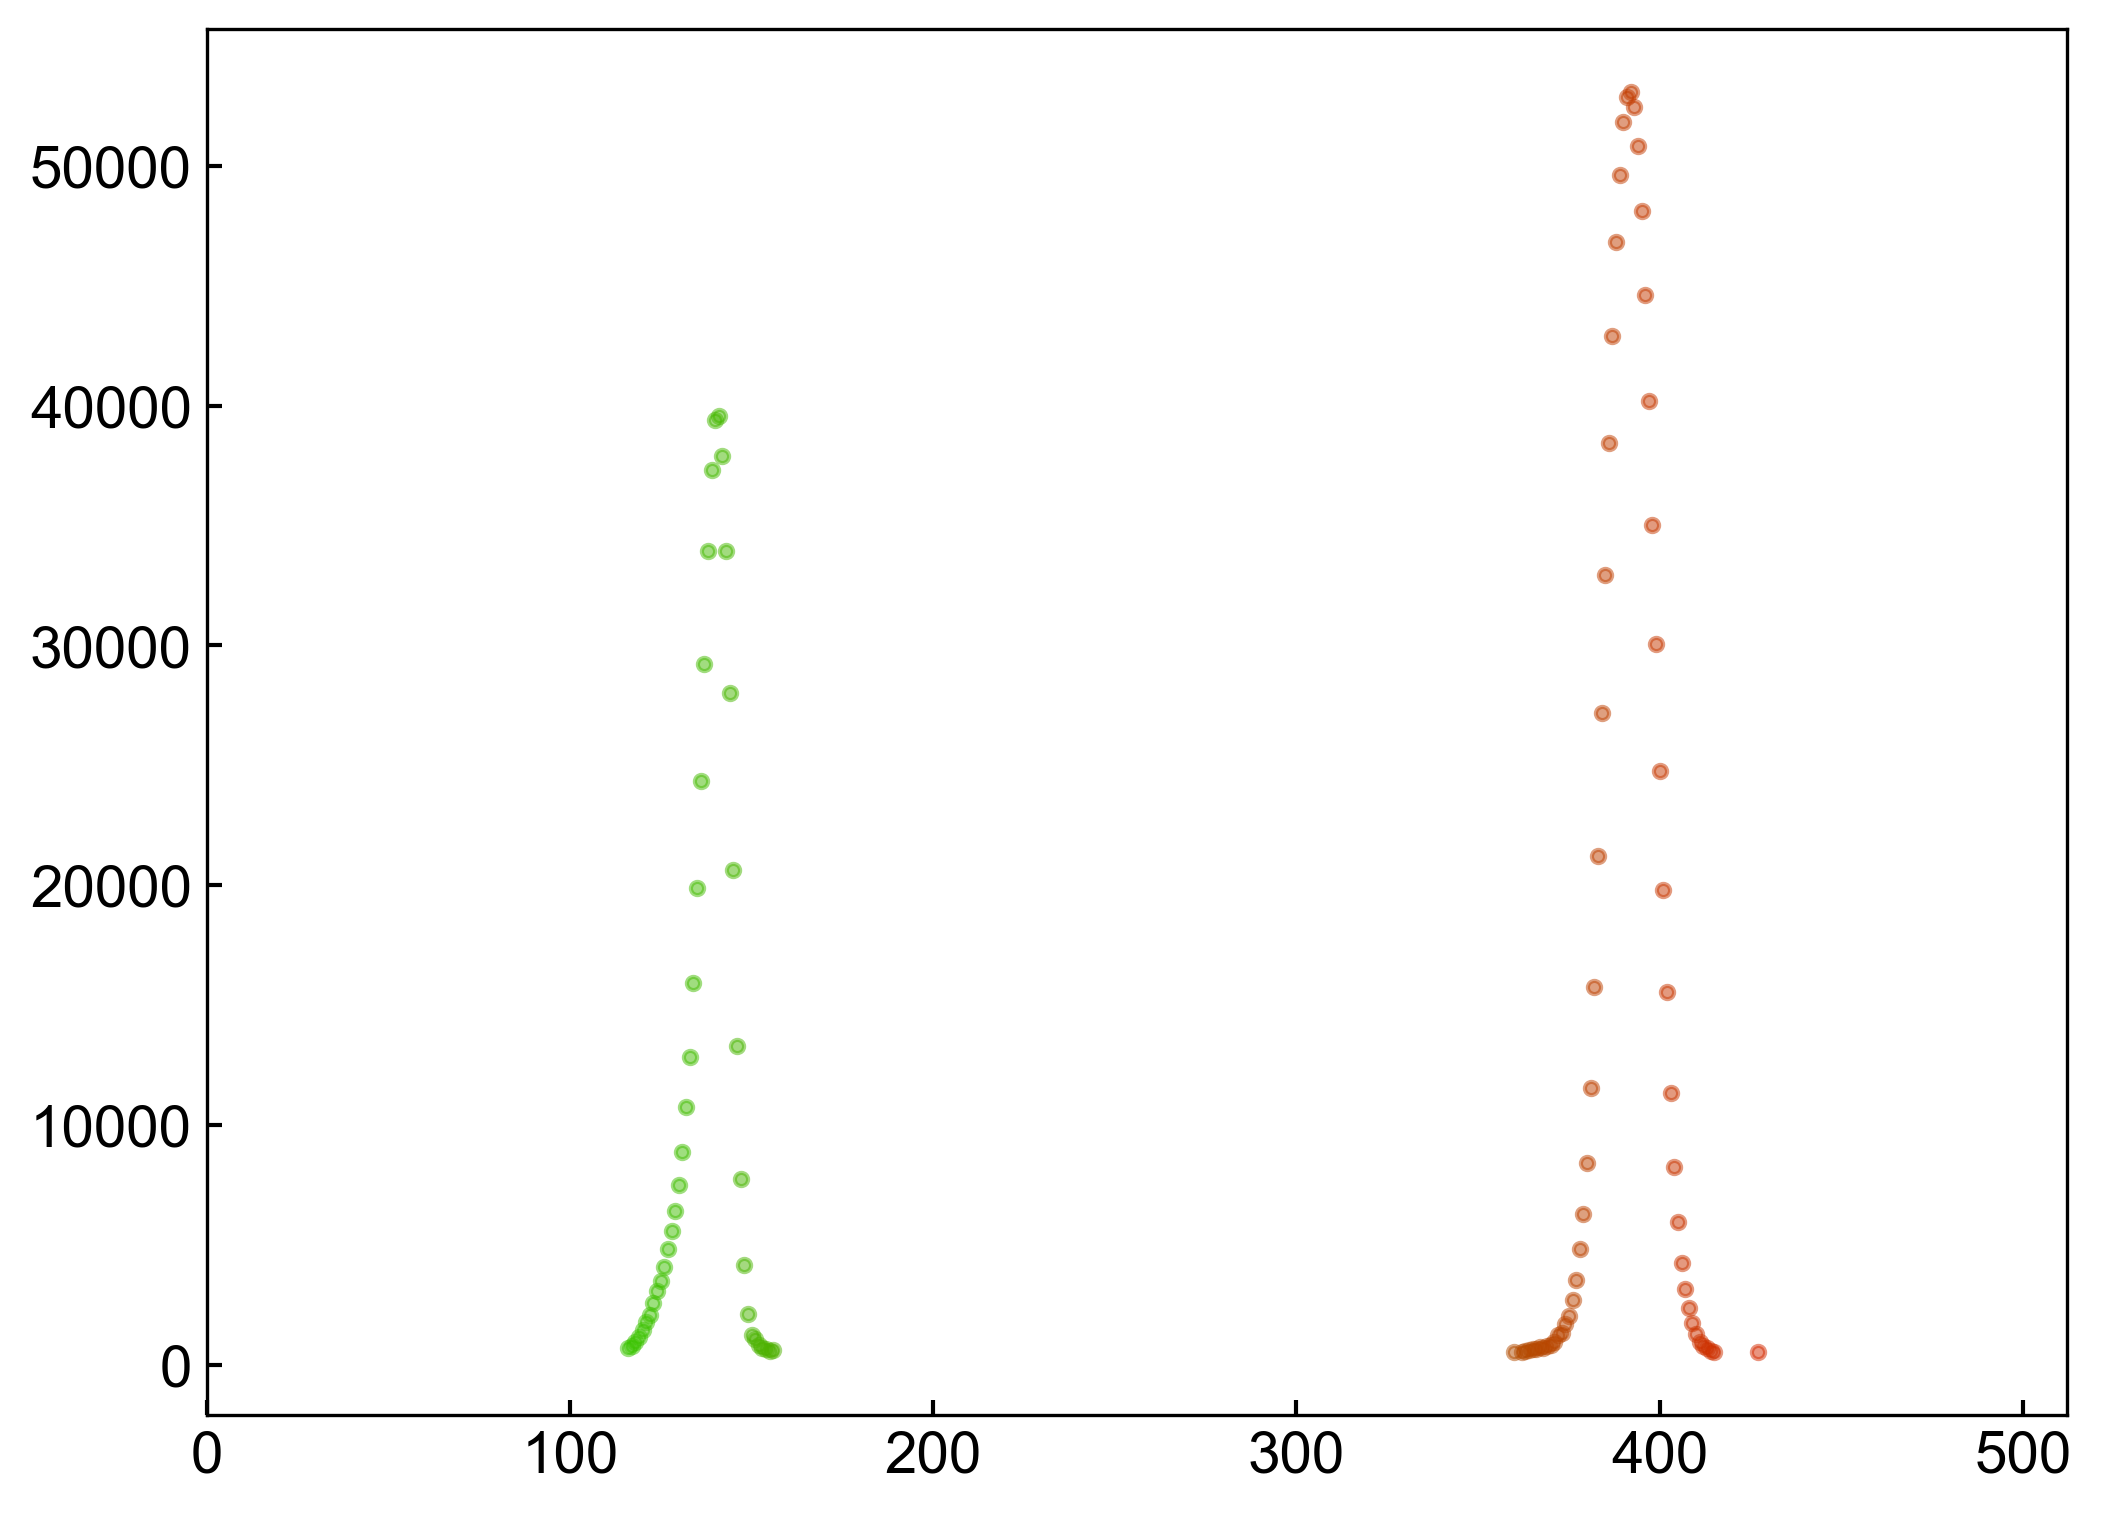

In [18]:
# fittingするべきpositionを可視化する
are_fitted_frames = image.max(axis=1) > threshold # boolean配列ができる
fitted_positions = np.where(are_fitted_frames)[0] # trueのframe数を格納した配列

fig, ax = plt.subplots()

for frame in fitted_positions:
    color = (frame/are_fitted_frames.shape[0], (are_fitted_frames.shape[0]-frame)/are_fitted_frames.shape[0], 0, 0.5)
    ax.scatter(frame, image[frame].max(), color=color, s=10)
    # ここで中心位置を取得
ax.set_xlim(0, are_fitted_frames.shape[0])
plt.show()
plt.close()

## ずれを定量するための最大位置推定

### 最大値に点を打つ

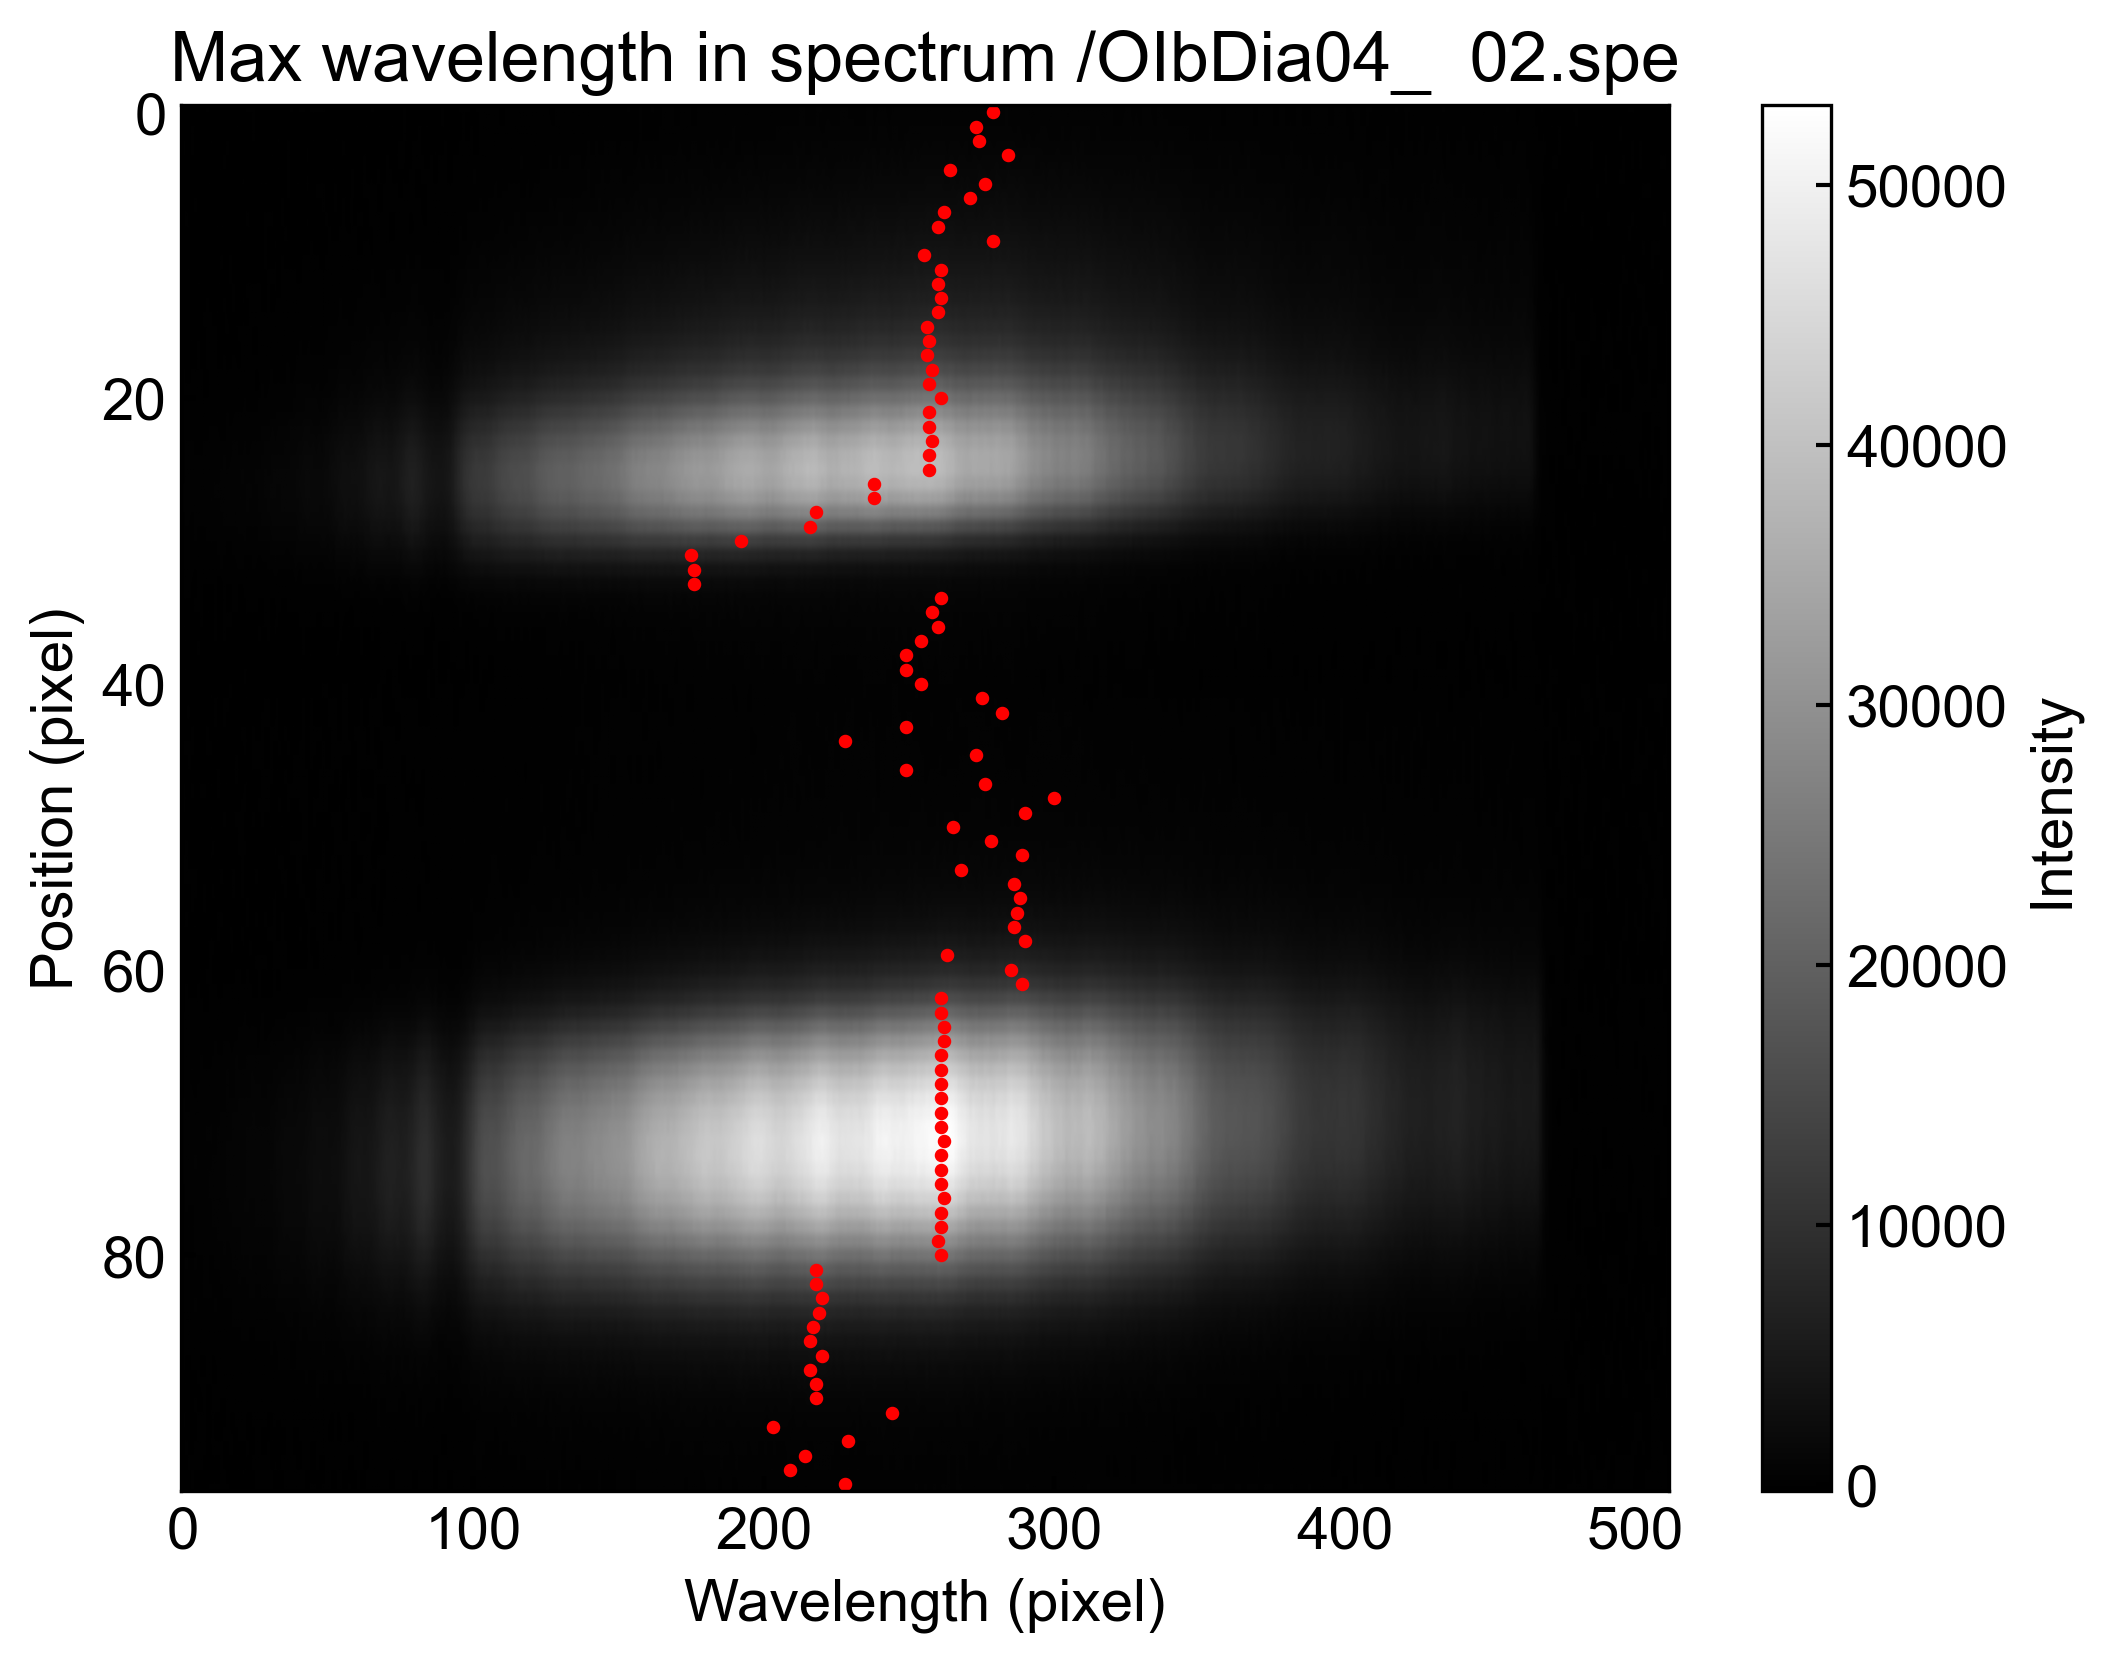

In [19]:
# ベースを描画
fig, ax = FigureMaker.get_exposure_image_figure(
    file_name,
    test_frame,
    image[fitted_positions],
)
# 最大波長の点を重ねる
ax.scatter(
    image[fitted_positions].argmax(axis=1),
    np.arange(fitted_positions.shape[0]),
    color='red',
    s=5
)
ax.set_title("Max wavelength in spectrum /" + file_name)
plt.show()
plt.close()

### 非対称ガウシアンfittingで中心位置に点を打つ

In [20]:
# fitted_framesに対して、それぞれの中心波長pixelを取得

# image[fitted_indices]
x_data = np.arange(image.shape[1])  # xデータ (0, 1, ..., 511)


In [21]:
# 1 frame分fitting。時間も図る
skew_fit_result = []

start_time = time.time()
for position in fitted_positions:
    y_data = image[position]
    skew_fit_result.append(RadiationFitter.fit_by_asymmetric_gaussian(x_data, y_data))
end_time = time.time()

end_time - start_time

0.06626486778259277

In [22]:
skew_fit_result

[{'parameters': {'A': np.float64(517.9389058759467),
   'mu': np.float64(269.6700094220964),
   'sigma1': np.float64(70.52334105629775),
   'sigma2': np.float64(90.81271019757754)},
  'covariance': array([[57.54977424,  0.14246157, -5.1172387 , -6.91548933],
         [ 0.14246157, 12.21170106,  9.17347405, -9.27541256],
         [-5.1172387 ,  9.17347405,  9.52922154, -6.34975381],
         [-6.91548933, -9.27541256, -6.34975381, 10.67738639]])},
 {'parameters': {'A': np.float64(652.0010107777335),
   'mu': np.float64(266.42630722979135),
   'sigma1': np.float64(67.24007399450933),
   'sigma2': np.float64(92.04593997395627)},
  'covariance': array([[58.85589296,  0.11370948, -3.96069447, -5.69225502],
         [ 0.11370948,  7.6123504 ,  5.71862293, -5.78239346],
         [-3.96069447,  5.71862293,  5.88837812, -3.95851126],
         [-5.69225502, -5.78239346, -3.95851126,  6.75202845]])},
 {'parameters': {'A': np.float64(813.0896287364603),
   'mu': np.float64(267.37643106508983),
   

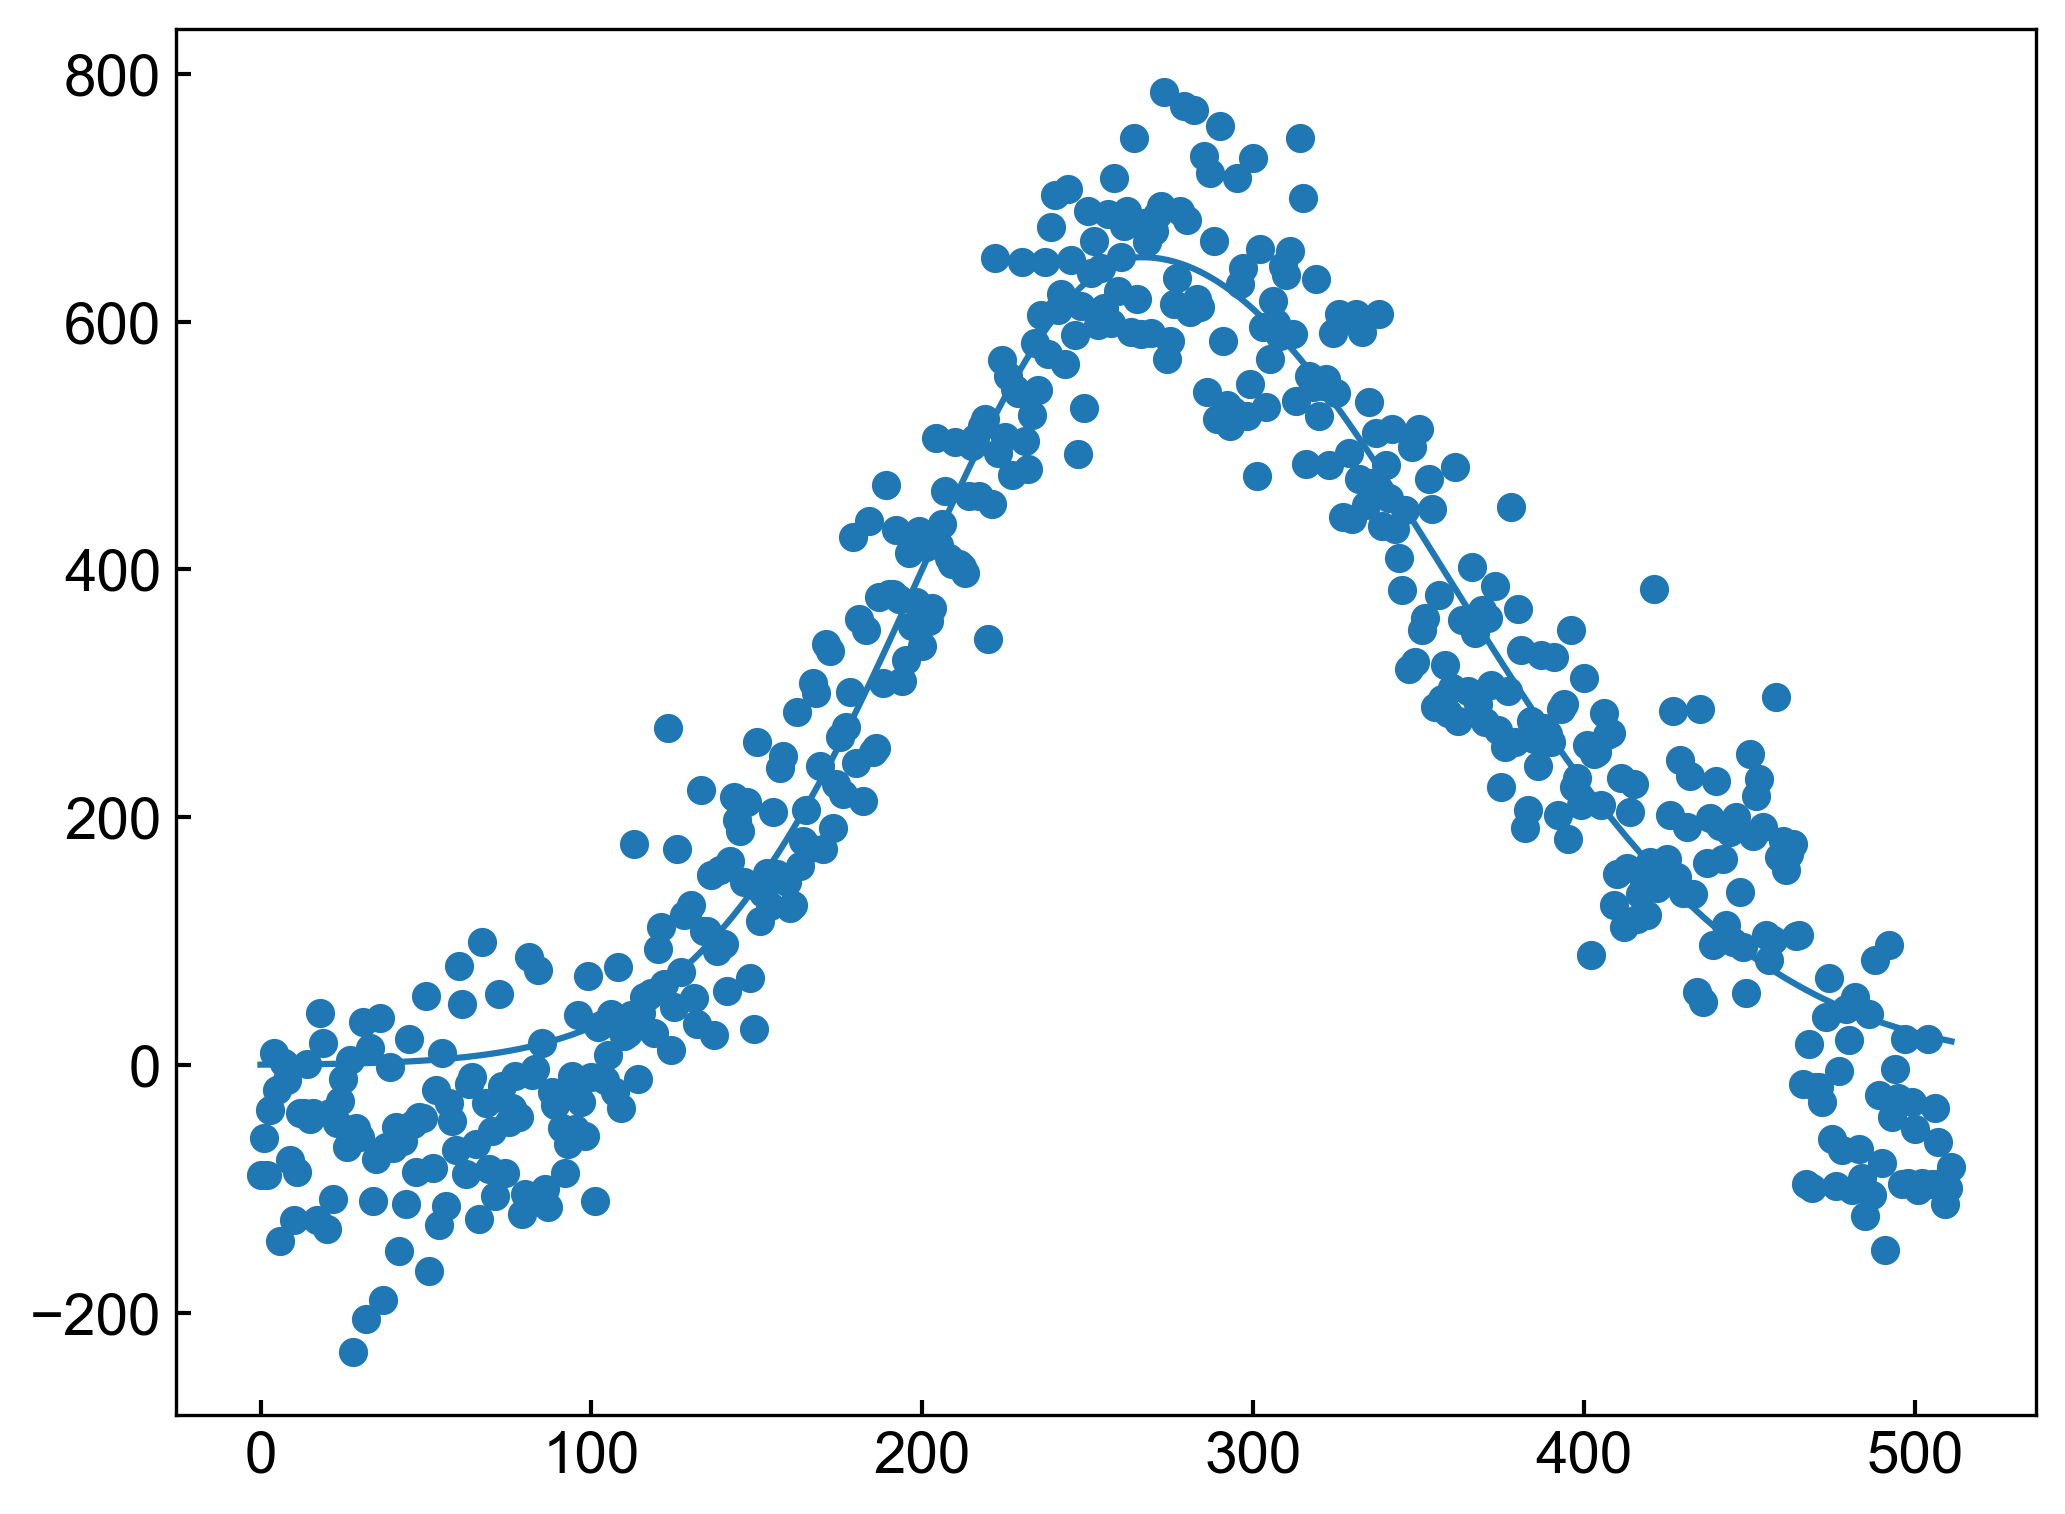

In [23]:
# 試しに1 pixel分確認
result = skew_fit_result[1]
A = result["parameters"]["A"]
mu = result["parameters"]["mu"]
sigma1 = result["parameters"]["sigma1"]
sigma2 = result["parameters"]["sigma2"]

# フィッティング結果の計算
fitted_y = RadiationFitter.asymmetric_gaussian(x_data, A, mu, sigma1, sigma2)

plt.plot(x_data, fitted_y)
plt.scatter(x_data, image[fitted_positions[1]])

In [24]:
# 中心位置を格納した配列を作る
fitted_center = []
for result in skew_fit_result:
    fitted_center.append(result["parameters"]["mu"])
fitted_center = np.array(fitted_center)

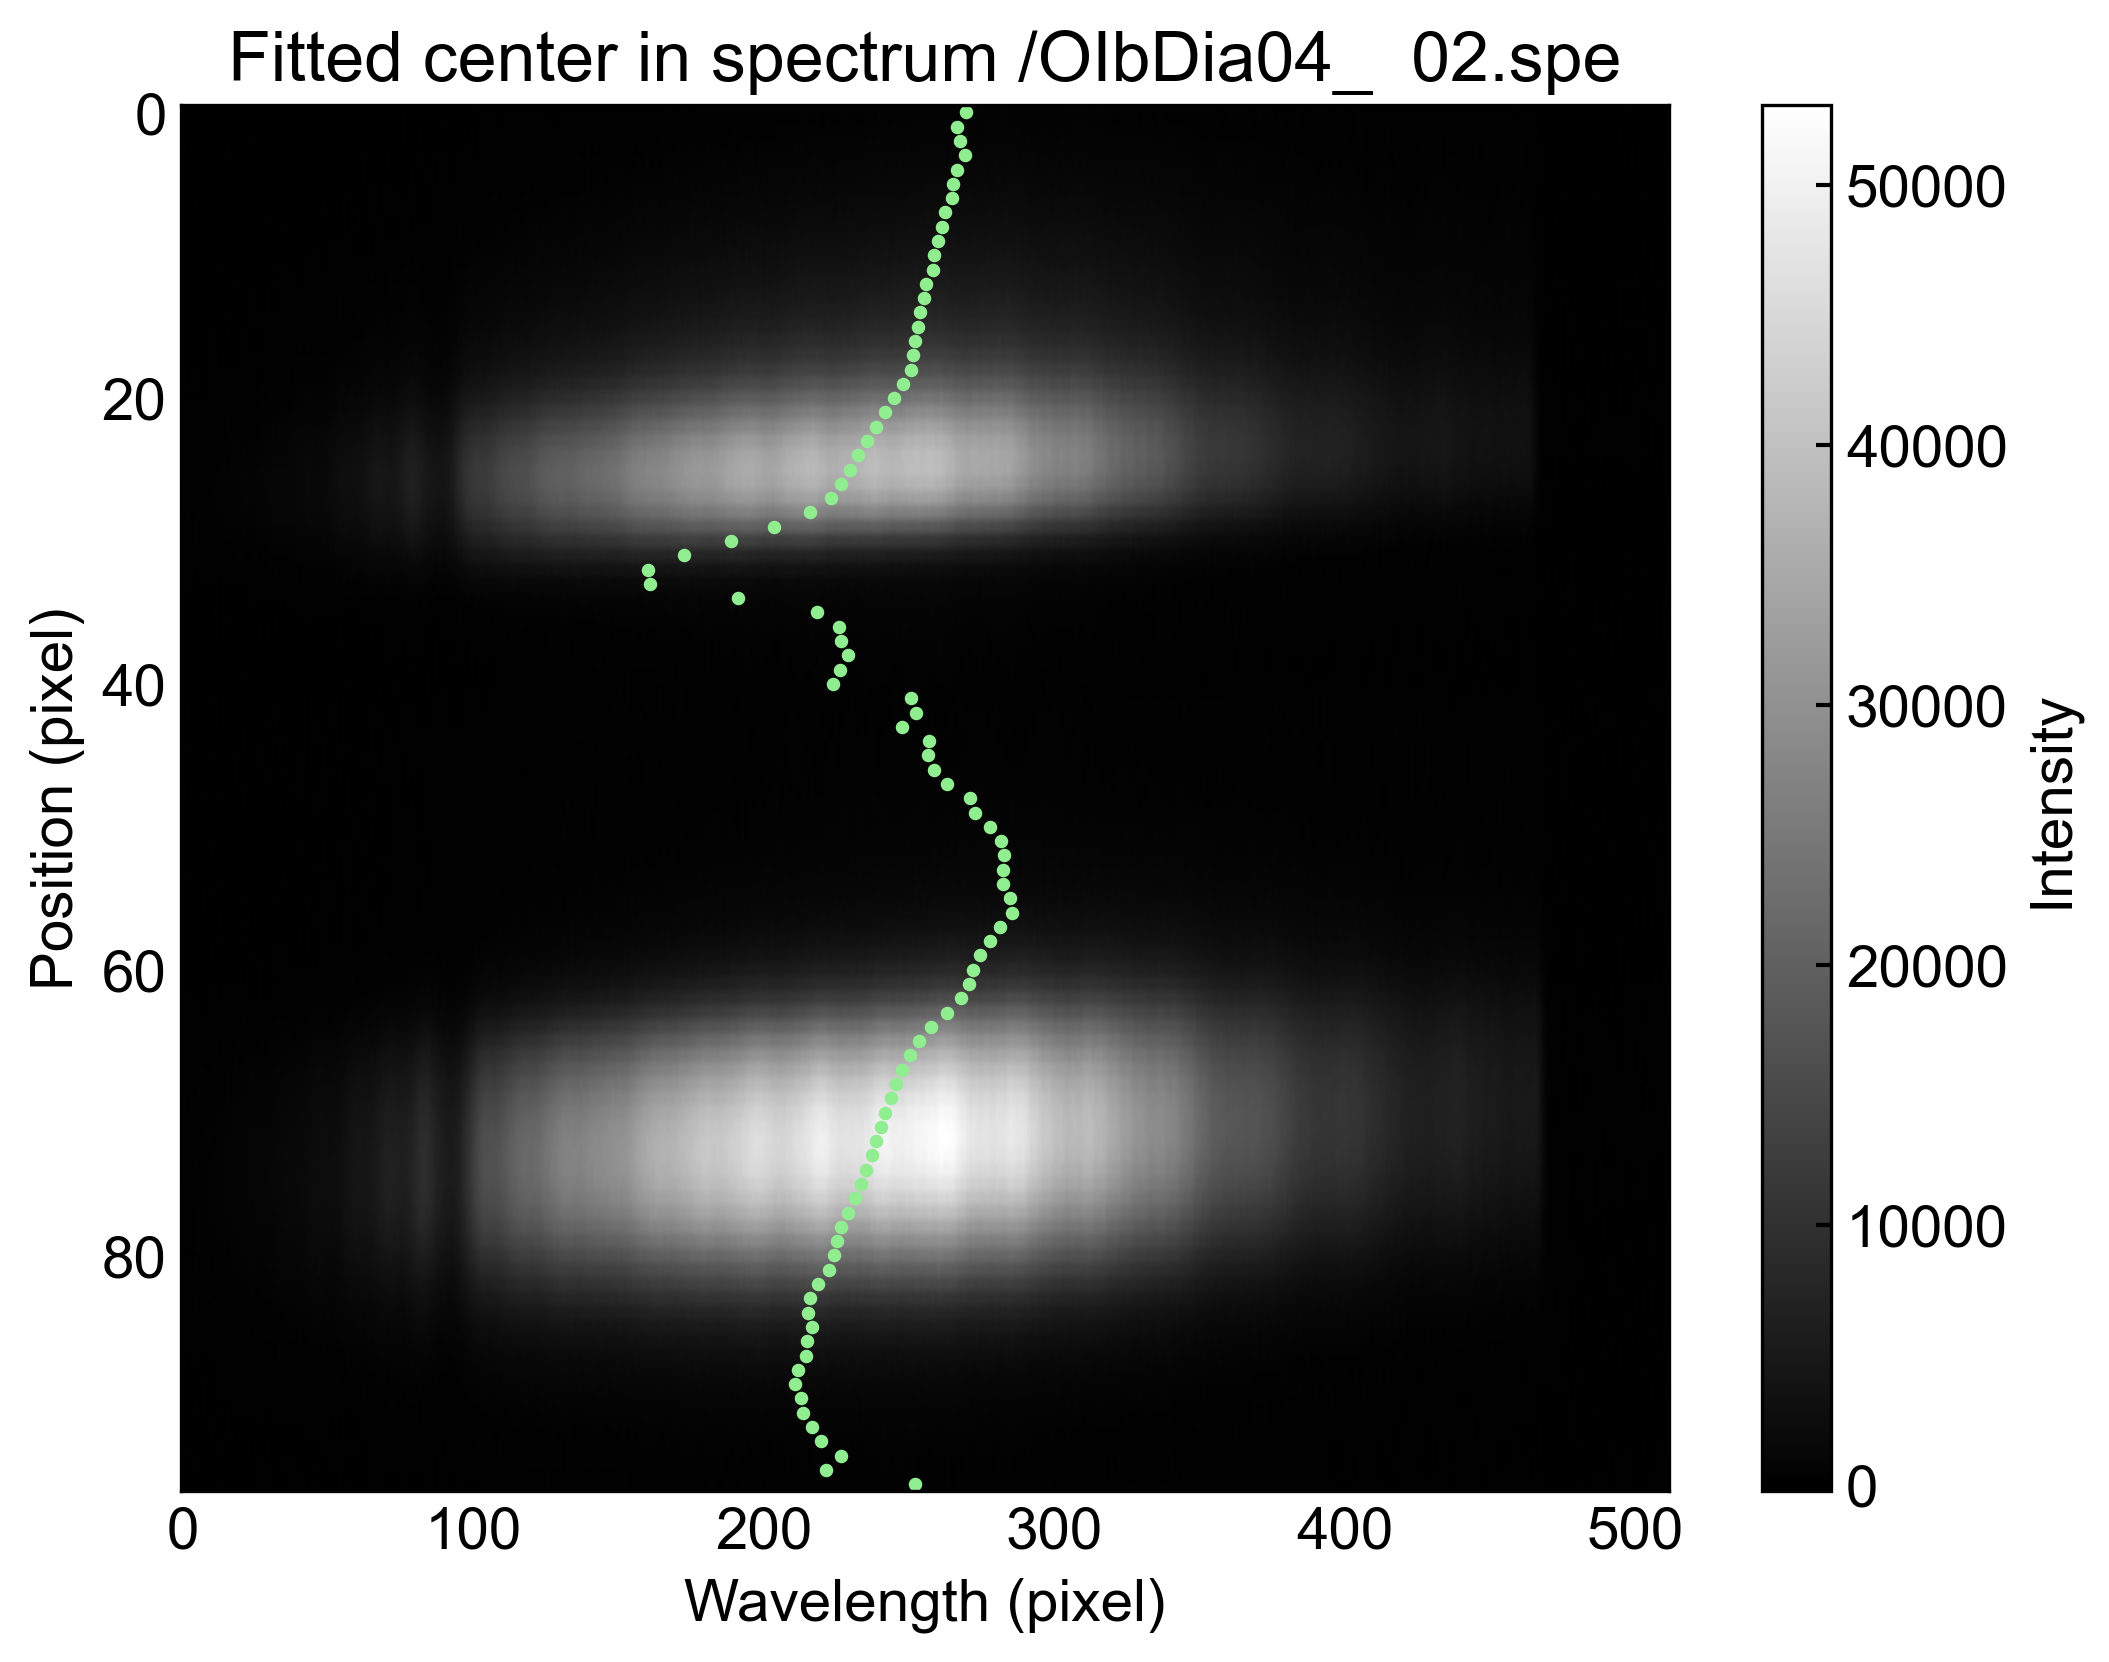

In [25]:
# ベースを描画
fig, ax = FigureMaker.get_exposure_image_figure(
    file_name,
    test_frame,
    image[fitted_positions],
)
# fitされた中心点を重ねる
ax.scatter(
    fitted_center,
    np.arange(fitted_positions.shape[0]), # 同じ
    color='lightgreen',
    s=5
)
ax.set_title("Fitted center in spectrum /" + file_name)
plt.show()
plt.close()


## 回転処理

In [26]:
# 角度を設定
rotate_deg = -0.5

### 全体を一括で回転

### 上下分けてそれぞれを回転

(256, 512) (256, 512)


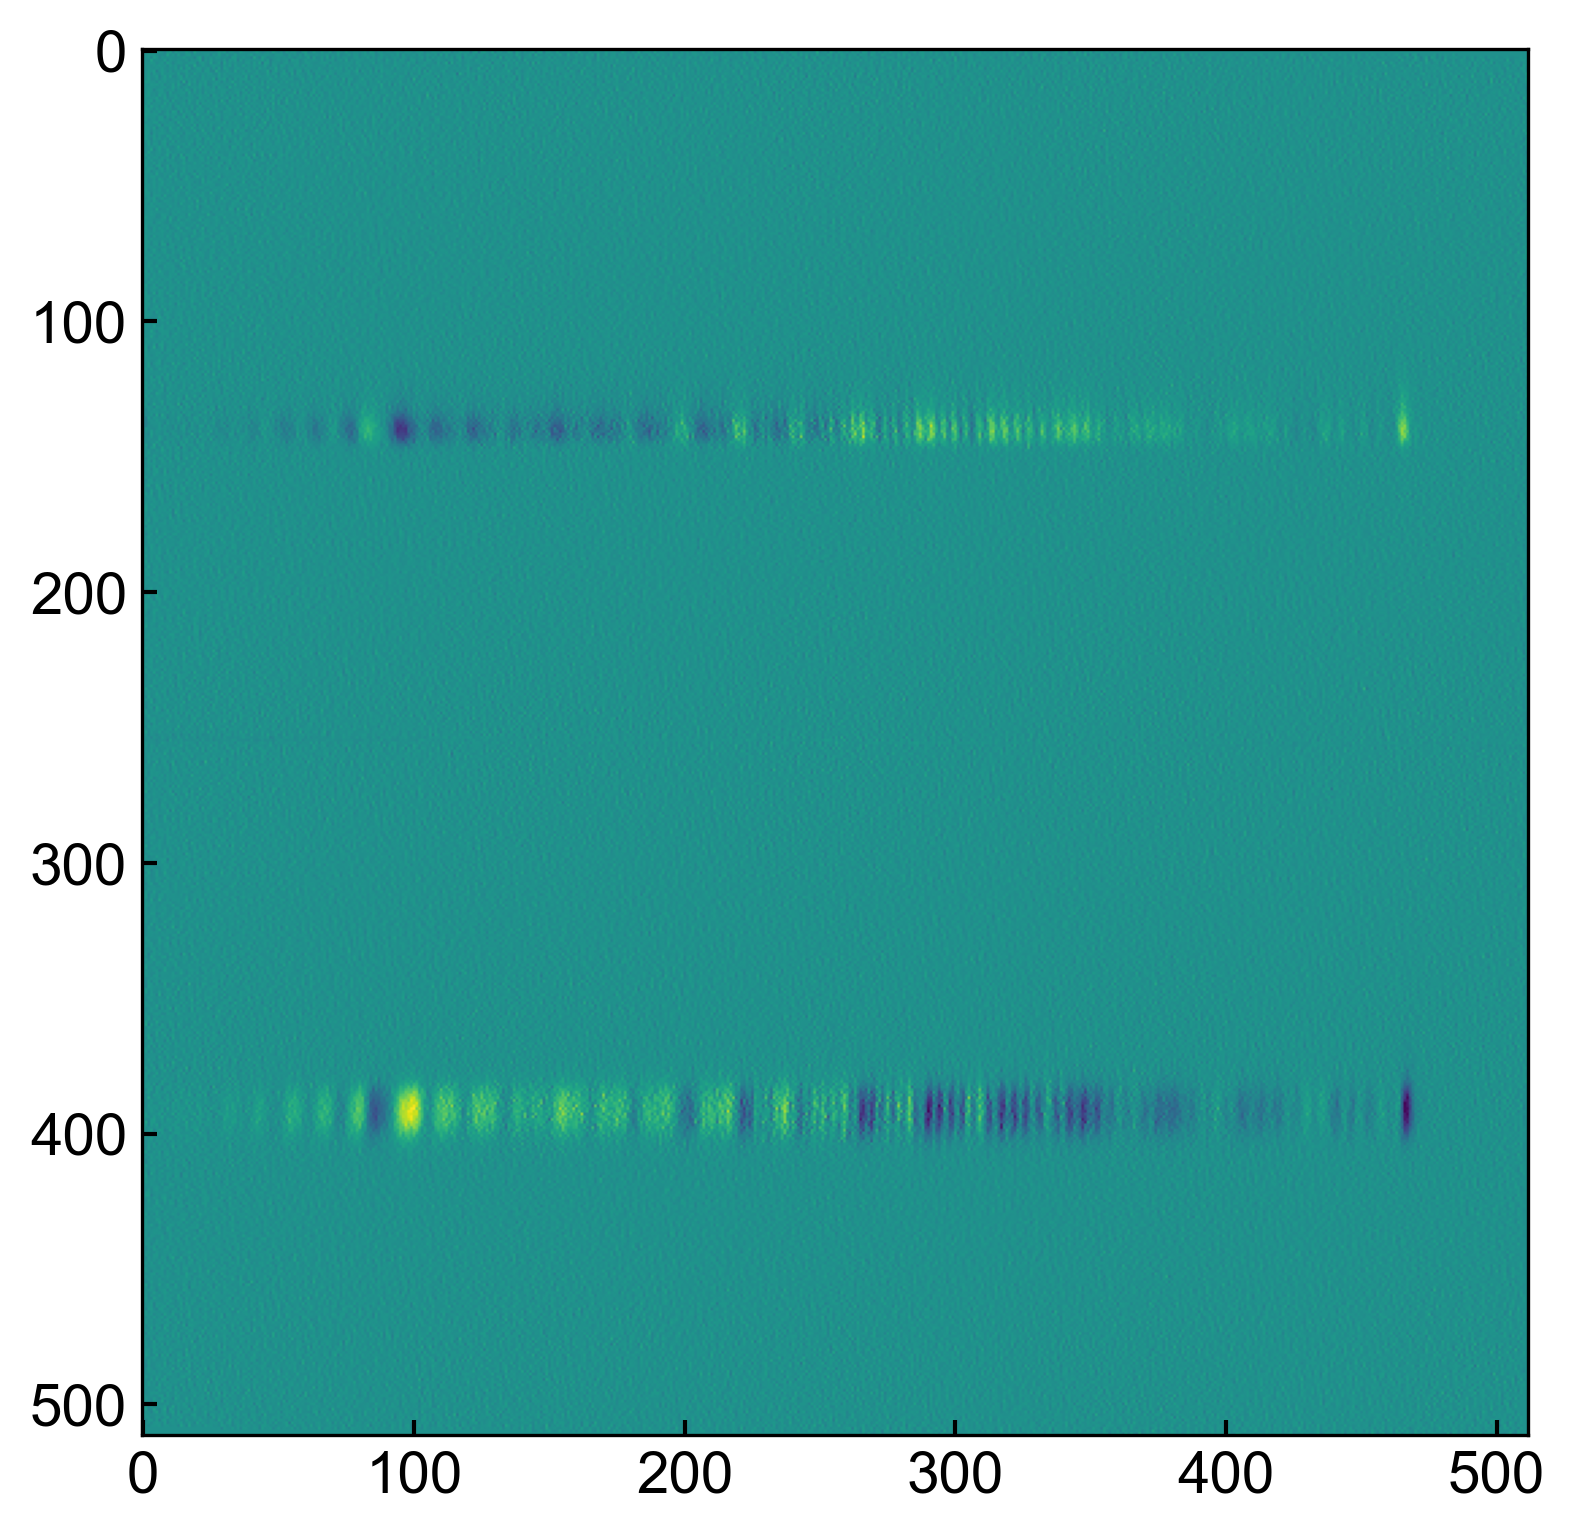

In [27]:
whole_rotated_image = original_radiation.get_rotated_image(
    test_frame,
    rotate_deg,
    'whole'
)

separate_rotated_image = original_radiation.get_rotated_image(
    test_frame,
    rotate_deg,
    'separate_half'
)

plt.imshow(whole_rotated_image - separate_rotated_image)
plt.show()
plt.close()

In [28]:
# オプションを制限するために作ったクラスの動作確認
RotateOption.from_str("whole")

<RotateOption.WHOLE: 'whole'>

## 中心位置を確認

## ファイルのコピー

In [29]:
# 保存先のフォルダ
path_to_save_dir = "/Users/ishizawaosamu/work/MasterThesis/test-data/spe-rotator"

# ファイル名どうする？ → {元のfilename}_{center or separate}_{回転角度}.spe
# 


In [30]:
# コピー


## コピー先のファイルに書き込み

## 差分を確認してプロット

## 回転履歴を保存

# End